# Import modules


In [ ]:
# %matplotlib widget

In [1]:
import copy
import pickle
import itertools
import os
from datetime import datetime, timedelta

import numpy as np
import matplotlib.pyplot as plt
# import matplotlib as mpl
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict, cross_validate 
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer, mean_absolute_percentage_error, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from scipy.stats.mstats import theilslopes
from scipy.optimize import curve_fit
from hampel import hampel

import shap

plt.rcParams['axes.edgecolor'] = 'blue'
plt.rcParams['figure.figsize'] = [14, 7]

In [2]:
import ee
import geemap.core as geemap

In [3]:
ee.Authenticate()

True

In [4]:
ee.Initialize(project='ee-airgit1')

In [5]:
def convert_degreendmin_to_degree(data_frame: pd.DataFrame, name_of_col: str):
    """Convert degree with minutes to degree

    Returns:
        pd.DataFrame: DataFrame where column "name_of_col" is swaped
    """

    data_list = data_frame[name_of_col].tolist()
    for i, item in enumerate(data_list):
        integer, frac = item.split(' ')
        data_list[i] = integer + str(float(frac) / 60)[1:]
    data_frame[name_of_col] = data_list
    return data_frame


def convert_datetime_irkutsk(data_frame: pd.DataFrame):
    """Convert columns "DATE", "TIME" to type "datetime" in gee (UTC-0)

    Returns:
        pd.DataFrame: DataFrame where columns "DATE", "TIME" are merged
    """

    converted_list = data_frame["DATE"].tolist()
    for i in range(converted_list.__len__()):
        tmp = converted_list[i].split('/')
        date = [tmp[-1], tmp[0], tmp[1]]
        converted_list[i] = '-'.join(date) + \
            ' ' + data_frame["TIME"][i] + ":00"
        dt_datetime = datetime.strptime(converted_list[i], '%Y-%m-%d %H:%M:%S')
        dt_datetime -= timedelta(hours=8)
        converted_list[i] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')

    data_frame["datetime"] = converted_list
    data_frame = data_frame.drop(columns=['DATE', 'TIME'])
    return data_frame

# Implementation


## Function definition

### preprocessing

In [6]:
def scale_modis1(image):
    bandList = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12',
                'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16']
    opticalBands = image.select(bandList).multiply(0.0001).divide(np.pi)
    return image.addBands(opticalBands, None, True)


# https://spatialthoughts.com/2021/08/19/qa-bands-bitmasks-gee/
def bitwiseExtract(input, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return input.rightShift(fromBit).bitwiseAnd(mask)


def mask_clouds_modis1(image):
    qa = image.select('QC_b8_15_1km')
    cloudsBitMask8 = bitwiseExtract(qa, 0, 3).eq(0)
    cloudsBitMask9 = bitwiseExtract(qa, 4, 7).eq(0)
    cloudsBitMask10 = bitwiseExtract(qa, 8, 11).eq(0)
    cloudsBitMask11 = bitwiseExtract(qa, 12, 15).eq(0)
    cloudsBitMask12 = bitwiseExtract(qa, 16, 19).eq(0)
    cloudsBitMask13 = bitwiseExtract(qa, 20, 23).eq(0)
    mask = cloudsBitMask8.And(cloudsBitMask9).And(cloudsBitMask10).And(cloudsBitMask11) \
        .And(cloudsBitMask12).And(cloudsBitMask13)
    
    bandList = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12',
                'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16']
    opticalBands = image.select(bandList)

    mask_gt = opticalBands.select(bandList).reduce(ee.Reducer.min()).gt(0)
    return image.updateMask(mask.And(mask_gt))


def scale_oli(image):
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2).divide(np.pi)
  return image.addBands(opticalBands, None, True)


# https://calekochenour.github.io/remote-sensing-textbook/03-beginner/chapter12-cloud-masking.html
def mask_clouds_landsat8(image):
  cloudsBitMask = (1 << 3)
  cloudShadowBitMask = (1 << 4)
  bandList = ['SR_B1', 'SR_B2', 'SR_B3']
  opticalBands = image.select(bandList)
  qa = image.select('QA_PIXEL')
  
  mask_gt = opticalBands.select(bandList).reduce(ee.Reducer.min()).gt(0)
  mask_lt = opticalBands.select(bandList).reduce(ee.Reducer.max()).lt(1)
  mask = qa \
    .bitwiseAnd(cloudShadowBitMask).eq(0) \
    .And(qa.bitwiseAnd(cloudsBitMask).eq(0))
  return image.updateMask(mask.And(mask_gt).And(mask_lt))


def preproc(ic: pd.DataFrame | list, df: pd.DataFrame, sensor: str) -> dict:
    """Mapping of id (datetime) to Image

    Args:
        ic (ee.ImageCollection): initial dataset
        df (pd.DataFrame): .csv
        sensor: modis or oli
    
    Returns:
        dictionary of list [image, dict of bands (out ReduceRegion)]
    """
    
    dict_stats = {key: value for key, value in zip(df.index.to_list(), df['datetime'].to_list())}
    match sensor:
        case "mod4":
            for i in dict_stats:
                date_of_observation = ee.Date(df['datetime'][i])
                start_date = date_of_observation.advance(-1, 'day')
                end_date = date_of_observation.advance(1, 'day')

                img = ic[0].merge(ic[1]).filterDate(start_date, end_date) \
                    .filterBounds(ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])))
                    
                found_stats = [None, None]
                if img.size().getInfo():
                    img = img.toList(img.size())
                    for j in range(img.length().getInfo()):
                        v_mean = ee.Image(img.get(j)).reduceRegion(
                                    reducer=ee.Reducer.median(),
                                    geometry=ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])),
                                    scale=4616
                                ).getInfo()
                        if v_mean['Rrs_412'] is not None:
                            found_stats[0] = ee.Image(img.get(j))
                            found_stats[1] = v_mean
                            break
                dict_stats[i] = found_stats
                
        case "mod1":
            for i in dict_stats:
                date_of_observation = ee.Date(df['datetime'][i])
                start_date = date_of_observation.advance(-1, 'day')
                end_date = date_of_observation.advance(1, 'day')

                img = ic[0].merge(ic[1]).filterDate(start_date, end_date) \
                    .filterBounds(ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i]))).map(scale_modis1).map(mask_clouds_modis1)
                
                found_stats = [None, None]
                if img.size().getInfo():
                    img = img.toList(img.size())
                    for j in range(img.length().getInfo()):
                        v_mean = ee.Image(img.get(j)).reduceRegion(
                                    reducer=ee.Reducer.median(),
                                    geometry=ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])),
                                    scale=1000
                                ).getInfo()
                        if v_mean['sur_refl_b08'] is not None:
                            found_stats[0] = ee.Image(img.get(j))
                            found_stats[1] = v_mean
                            break
                dict_stats[i] = found_stats
        
        case "oli":
            for i in dict_stats:
                date_of_observation = ee.Date(df['datetime'][i])
                start_date = date_of_observation.advance(-1, 'day')
                end_date = date_of_observation.advance(1, 'day')
                
                img = ic.filterDate(start_date, end_date) \
                    .filterBounds(ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i]))).map(scale_oli).map(mask_clouds_landsat8)
                found_stats = [None, None]
                if img.size().getInfo():
                    img = img.toList(img.size())
                    for j in range(img.length().getInfo()):
                        v_mean = ee.Image(img.get(j)).reduceRegion(
                                    reducer=ee.Reducer.median(),
                                    geometry=ee.Geometry.Point(float(df['LONGITUDE'][i]), float(df['LATITUDE'][i])),
                                    scale=30
                                ).getInfo()
                        if v_mean['SR_B3'] is not None:
                            found_stats[0] = ee.Image(img.get(j))
                            found_stats[1] = v_mean
                            break
                dict_stats[i] = found_stats
        
    for k, v in list(dict_stats.items()):
        if v[1] is None:
            del dict_stats[k]
    
    # for k, v in dict_stats.items():
    #     display(v[0])
    #     display(df[df['ID'] == k])
    return dict_stats


def clean_negative_rrs(dict_stats: dict, sensor: str) -> dict:
    dict_clean_stats = copy.deepcopy(dict_stats)
    match sensor:
        case "mod4":
            bands = ['Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678']
        case "mod1":
            bands = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12',
                'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16']
        case "oli":
            bands = ['SR_B1', 'SR_B2', 'SR_B3']
    
    for k, v in dict_stats.items():
        for b in bands:
            if v[1][b] < 0:
                del dict_clean_stats[k]
                break
    
    return dict_clean_stats

### draw and calculate conc

In [7]:
sns.set_style("whitegrid")

In [26]:
def draw_graphic(list1: list, list2: list, name_algo: str, save_folder: str = None):
    x = np.array(copy.deepcopy(list1)).reshape((-1, 1))
    y1 = np.array(copy.deepcopy(list2))
    model = LinearRegression().fit(x, y1)
    x_dots = np.linspace(x.min(), x.max(), 100).reshape((-1, 1))
    x_dots = np.linspace(0, 6.56, 100).reshape((-1, 1))
    y_pred = model.predict(x_dots)
    
    plt.figure()
    plt.scatter(x, y1, c=[(0.7, 0.2, 0.9)], s=150,
                edgecolor='black',      # Черная обводка
                linewidth=1.5,         # Толщина обводки
                alpha=0.9,             # Легкая прозрачность
                marker='o',            # Форма маркера
                zorder=3)
    plt.plot(x_dots, y_pred, color='blue', label='linear regression')
    plt.plot(x_dots, (st := theilslopes(list2, list1)).slope * x_dots + st.intercept, color='green', label='Theil–Sen estimator')
    plt.plot(x_dots, x_dots, '--', color='black', label='1:1 line')
    plt.xlabel(f"in_situ, Ug/L\nN = {len(list1)}, Sen\'s slope = {st.slope:.3f}", fontsize=16, labelpad=10)
    plt.ylabel(f"{name_algo}, Ug/L", fontsize=16, labelpad=10)# Задание диапазона по оси x
    plt.xlim(0, 6.6)
    plt.xlim(0, 6.6)
    plt.tick_params(labelsize=14, pad=10)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if save_folder:
        os.makedirs(f"graphics/{save_folder}", exist_ok=True)
        filename = f"{name_algo}.png"
        save_path = os.path.join(f"graphics/{save_folder}", filename)
        
        plt.savefig(save_path, bbox_inches="tight")
        plt.close()  # Закрыть фигуру после сохранения
    else:
        plt.show()   # Показать график, если сохранение не требуется
    return round(model.coef_[0], 3)


def draw_graphic_and_calculate_chl(mbr: dict, df_in_situ: pd.DataFrame, coeff_poly: list, name_algo: str, algo="orelly"):
    dict_in_situ = {key: value for key, value in zip(df_in_situ.index.to_list(), df_in_situ['CHL'].to_list())}
    if algo == "orelly":
        for k in list(mbr.keys()):
            mbr[k] = 10 ** (coeff_poly[0] + coeff_poly[1] * np.log10(mbr[k]) + coeff_poly[2] * np.log10(mbr[k])**2 + 
                                coeff_poly[3] * np.log10(mbr[k])**3 + coeff_poly[4] * np.log10(mbr[k])**4)
            
            if abs(dict_in_situ[k] - mbr[k]) > 100:
                print("\tBig:", k, dict_in_situ [k], mbr[k])
                del mbr[k]
            # else:
            #     print(f"ID: {k}, in situ: {dict_in_situ[k]}, chl: {mbr[k]}, dif: {abs(dict_in_situ[k] - mbr[k])}")
    else:
        for k in list(mbr.keys()):
            if abs(dict_in_situ [k] - mbr[k]) > 15:
                print("Big:", k)
                del mbr[k]
                
    for k in list(dict_in_situ.keys()):
        if k not in mbr:
            del dict_in_situ[k]
    
    in_situ_values = list(dict_in_situ.values())
    mbr_values = list(mbr.values())
    _s = draw_graphic(in_situ_values, mbr_values, name_algo, save_folder="ocean")
    return dict_in_situ, mbr, _s


def mae(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += abs(np.log10(y_pred_pos[i]) - np.log10(ai))
    res /= len(in_situ)
    return 10 ** res


def bias_abs(in_situ, pred):
    res = 0
    for i, ai in enumerate(in_situ):
        res += (pred[i] - ai)
    return res / len(in_situ)


def bias(in_situ, pred):
    res = 0
    y_pred_pos = np.maximum(np.array(pred), 0.01)
    for i, ai in enumerate(in_situ):
        res += np.log10(y_pred_pos[i]) - np.log10(ai)
    res /= len(in_situ)
    return 10 ** res


def sensslope(in_situ, pred):
    return theilslopes(pred, in_situ).slope


def r2_cov(y, y_pred):
    y = np.log10(np.array(y))
    y_pred = np.log10(np.array(y_pred))
    y_bar = y.mean()
    y_pred_bar = y_pred.mean()
    return np.pow(np.sum((y - y_bar) * (y_pred - y_pred_bar)) /
                  np.sqrt(np.sum(np.pow(y - y_bar, 2)) * np.sum(np.pow(y_pred - y_pred_bar, 2))), 2)


def std(in_situ, pred):
    return np.std(np.array(pred) - np.array(in_situ))


def statistics(dict_in_situ, dict_calc):
    if isinstance(dict_in_situ, dict): list_in_situ, list_calc = list(dict_in_situ.values()), list(dict_calc.values())
    else: list_in_situ, list_calc = dict_in_situ, dict_calc
    arr = [r2_cov(list_in_situ, list_calc), bias(list_in_situ, list_calc),
            bias_abs(list_in_situ, list_calc), mae(list_in_situ, list_calc), mean_absolute_error(list_in_situ, list_calc),
            np.sqrt(mean_squared_error(list_in_situ, list_calc)), std(list_in_situ, list_calc),
            sensslope(list_in_situ, list_calc), mean_absolute_percentage_error(list_calc, list_in_situ) * 100]
    return list(map(lambda x: round(x, 3), arr)) 

### main

In [9]:
def convert_stat_dict_to_list_stat_and_values(arg_dict):
    """
    Args:
        arg_dict: {"name_algo1": [r2, bias, mae, n, {id: in situ}, {id: calculated}], "name_algo2": ...}
    
    Return: [{statustics (4 keys)}, {"name_algo" : [{id: in situ}, {id: calculated}]}]
    """
    statistics_dict = {}
    data_dict = {}
    for algo_name, algo_list in arg_dict.items():
        statistics_dict[algo_name] = algo_list[:-2]
        data_dict[algo_name] = [algo_list[-2], algo_list[-1]]
    return [statistics_dict, data_dict]

In [10]:
def main(dict_stats: dict, df: pd.DataFrame, sensor: str):
    """Draw graphics and calculate satistics for each algo

    Args:
        dict_stats (dict): {id: [ee.Image, dict{bands: value}]}
        df (pd.DataFrame): .csv
        sensor (int): mod1, mod4, oli

    Returns:
        {name_algo: []}
    """
    
    statistics_dict = {}
    match sensor:
        case "mod4":
            oc6_modis = dict()
            oc5_modis = dict()
            oc4_modis = dict()
            oc3_modis = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                oc5_modis[k] = max(v_mean['Rrs_412'], v_mean['Rrs_443'], v_mean['Rrs_488'],
                                v_mean['Rrs_531']) / v_mean['Rrs_555']
                oc4_modis[k] = max(v_mean['Rrs_412'], v_mean['Rrs_443'], v_mean['Rrs_488']) / v_mean['Rrs_555']
                oc3_modis[k] = max(v_mean['Rrs_443'], v_mean['Rrs_488']) / v_mean['Rrs_555']
                oc6_modis[k] = max(v_mean['Rrs_412'], v_mean['Rrs_443'], v_mean['Rrs_488'],
                                v_mean['Rrs_531']) / ((v_mean['Rrs_555'] + v_mean['Rrs_667']) / 2)
                    
            in_situ_list_oc6m, chl_pred_list_oc6m, _s = draw_graphic_and_calculate_chl(oc6_modis, df, [1.22914, -4.99423, 5.64706, -3.53426, 0.69266],
                                                                f"oc6_modis_4km")
            statistics_dict[f"oc6_modis_4km"] = [*statistics(in_situ_list_oc6m, chl_pred_list_oc6m), len(in_situ_list_oc6m),
                                    in_situ_list_oc6m, chl_pred_list_oc6m]
            # statistics_dict["oc6_modis_4km"].insert(6, _s)
              
            in_situ_list_oc5m, chl_pred_list_oc5m, _s = draw_graphic_and_calculate_chl(oc5_modis, df, [0.42919, -4.88411, 9.57678, -9.24289, 2.51916],
                                                                f"oc5_modis_4km")
            statistics_dict[f"oc5_modis_4km"] = [*statistics(in_situ_list_oc5m, chl_pred_list_oc5m), len(in_situ_list_oc5m),
                                    in_situ_list_oc5m, chl_pred_list_oc5m]
            # statistics_dict["oc5_modis_4km"].insert(6, _s)
            
            in_situ_list_oc4m, chl_pred_list_oc4m, _s = draw_graphic_and_calculate_chl(oc4_modis, df, [0.27015, -2.47936, 1.53752, -0.13967, -0.66166],
                                                                f"oc4_modis_4km")
            statistics_dict[f"oc4_modis_4km"] = [*statistics(in_situ_list_oc4m, chl_pred_list_oc4m), len(in_situ_list_oc4m),
                                    in_situ_list_oc4m, chl_pred_list_oc4m]
            # statistics_dict["oc4_modis_4km"].insert(6, _s)
            
            in_situ_list_oc3m, chl_pred_list_oc3m, _s = draw_graphic_and_calculate_chl(oc3_modis, df, [0.26294, -2.64669, 1.28364, 1.08209, -1.76828],
                                                                f"oc3_modis_4km")
            statistics_dict[f"oc3_modis_4km"] = [*statistics(in_situ_list_oc3m, chl_pred_list_oc3m), len(in_situ_list_oc3m),
                                    in_situ_list_oc3m, chl_pred_list_oc3m]
            # statistics_dict["oc3_modis_4km"].insert(6, _s)
              
        case "mod1":
            oc6_modis = dict()
            oc5_modis = dict()
            oc4_modis = dict()
            oc3_modis = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                oc5_modis[k] = max(v_mean['sur_refl_b08'], v_mean['sur_refl_b09'], v_mean['sur_refl_b10'],
                                    v_mean['sur_refl_b11']) / v_mean['sur_refl_b12']
                oc4_modis[k] = max(v_mean['sur_refl_b08'], v_mean['sur_refl_b09'], v_mean['sur_refl_b10']) / v_mean['sur_refl_b12']
                oc3_modis[k] = max(v_mean['sur_refl_b09'], v_mean['sur_refl_b10']) / v_mean['sur_refl_b12']
                oc6_modis[k] = max(v_mean['sur_refl_b08'], v_mean['sur_refl_b09'], v_mean['sur_refl_b10'],
                                    v_mean['sur_refl_b11']) / ((v_mean['sur_refl_b12'] + v_mean['sur_refl_b13']) / 2)
                    
            in_situ_list_oc6m, chl_pred_list_oc6m, _s = draw_graphic_and_calculate_chl(oc6_modis, df, [1.22914, -4.99423, 5.64706, -3.53426, 0.69266],
                                                                 f"oc6_modis_1km")
            statistics_dict[f"oc6_modis_1km"] = [*statistics(in_situ_list_oc6m, chl_pred_list_oc6m), len(in_situ_list_oc6m),
                                       in_situ_list_oc6m, chl_pred_list_oc6m]
            # statistics_dict["oc6_modis_1km"].insert(6, _s)
            
            in_situ_list_oc5m, chl_pred_list_oc5m, _s = draw_graphic_and_calculate_chl(oc5_modis, df, [0.42919, -4.88411, 9.57678, -9.24289, 2.51916],
                                                                 f"oc5_modis_1km")
            statistics_dict[f"oc5_modis_1km"] = [*statistics(in_situ_list_oc5m, chl_pred_list_oc5m), len(in_situ_list_oc5m),
                                       in_situ_list_oc5m, chl_pred_list_oc5m]
            # statistics_dict["oc5_modis_1km"].insert(6, _s)
            
            in_situ_list_oc4m, chl_pred_list_oc4m, _s = draw_graphic_and_calculate_chl(oc4_modis, df, [0.27015, -2.47936, 1.53752, -0.13967, -0.66166],
                                                                 f"oc4_modis_1km")
            statistics_dict[f"oc4_modis_1km"] = [*statistics(in_situ_list_oc4m, chl_pred_list_oc4m), len(in_situ_list_oc4m),
                                       in_situ_list_oc4m, chl_pred_list_oc4m]
            # statistics_dict["oc4_modis_1km"].insert(6, _s)
            
            in_situ_list_oc3m, chl_pred_list_oc3m, _s = draw_graphic_and_calculate_chl(oc3_modis, df, [0.26294, -2.64669, 1.28364, 1.08209, -1.76828],
                                                                 f"oc3_modis_1km")
            statistics_dict[f"oc3_modis_1km"] = [*statistics(in_situ_list_oc3m, chl_pred_list_oc3m), len(in_situ_list_oc3m),
                                       in_situ_list_oc3m, chl_pred_list_oc3m]
            # statistics_dict["oc3_modis_1km"].insert(6, _s)
            
            
        case "oli":
            oc3_oli = dict()
            for k, v in dict_stats.items():
                v_mean = v[1]
                oc3_oli[k] = max(v_mean['SR_B1'], v_mean['SR_B2']) / v_mean['SR_B3']
            
            in_situ_list_oc3o, chl_pred_list_oc3o, _s = draw_graphic_and_calculate_chl(oc3_oli, df, [0.30963, -2.40052, 1.28932, 0.52802, -1.33825],
                                                                 "oc3_oli")
            statistics_dict["oc3_oli"] = [*statistics(in_situ_list_oc3o, chl_pred_list_oc3o), len(in_situ_list_oc3o),
                                     in_situ_list_oc3o, chl_pred_list_oc3o]
            statistics_dict["oc3_oli"].insert(6, _s)
        
    return statistics_dict

## EDA

In [11]:
_df_irk = pd.read_csv("data_chl/irk_all.csv")
_df_sev = pd.read_csv('data_chl/sevastopol.csv', index_col=0)

for k in _df_sev.datetime.index:
    dt_datetime = datetime.strptime(_df_sev.loc[k, 'datetime'], '%Y-%m-%d %H:%M:%S')
    _df_sev.loc[k, 'datetime'] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')
_df_sev.rename(columns={'Latitude': 'LATITUDE', 'Longitude': 'LONGITUDE'}, inplace=True)

wind_values = np.array(_df_irk['Wind'].tolist())
wind_values = np.strings.replace(wind_values, ',', '.')
for i, ai in enumerate(wind_values):
    if '(' in ai:
        wind_values[i] = ai[ai.find('(') + 1 : ai.find(')')]
    elif '-' in ai:
        wind_values[i] = np.nan
    elif 'штиль' in ai:
        wind_values[i] = 0.3
wind_values = np.array(wind_values, dtype='float')

_df_irk["Wind"] = wind_values
_df_irk = convert_datetime_irkutsk(_df_irk)  
_df_all = pd.concat([_df_irk, _df_sev])
# df_all = _df_irk.merge(_df_sev, how='outer')

In [26]:
_df_all['CHL'].describe()

count    324.000000
mean       1.646449
std        0.817802
min        0.120000
25%        1.080000
50%        1.535000
75%        2.064764
max        6.560000
Name: CHL, dtype: float64

In [12]:
df_all = copy.deepcopy(_df_all)

In [16]:
THRESHOLD = _df_all['CHL'].quantile(0.95)
df_all = _df_all[_df_all['CHL'] <= THRESHOLD]

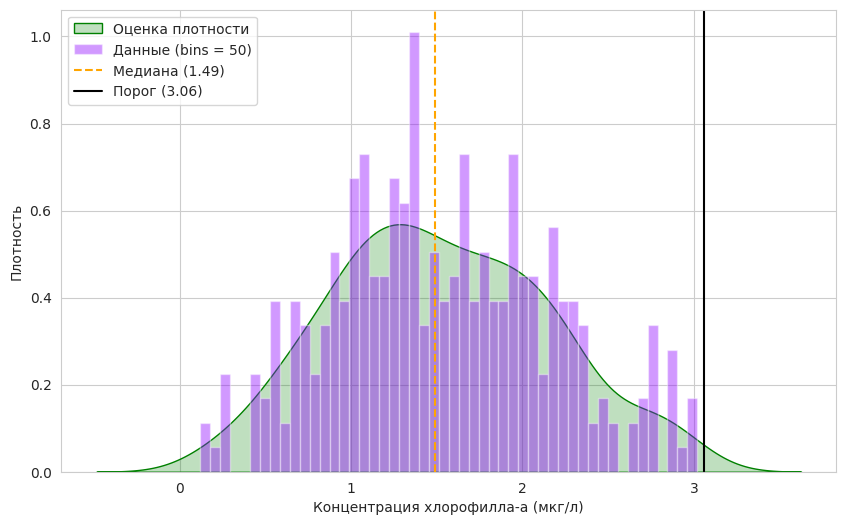

In [17]:
chl_a = df_all['CHL'].to_numpy()
bins = 50
plt.figure(figsize=(10, 6))
sns.kdeplot(chl_a, fill=True, color='green', label="Оценка плотности")
plt.hist(chl_a.reshape(-1, 1), bins=bins, density=True, alpha=0.4, label=f"Данные (bins = {bins})", color=(0.55, 0.0, 1))
plt.axvline(x=df_all['CHL'].median(), color='orange', linestyle='--', label=f"Медиана ({df_all['CHL'].median():.2f})")
plt.axvline(x=THRESHOLD, color="black", linestyle="-", label=f"Порог ({THRESHOLD:.2f})")
plt.xlabel("Концентрация хлорофилла-a (мкг/л)")
plt.ylabel("Плотность")
plt.legend();

In [13]:
ic_mod4_aqua = (
    ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")
    .filterDate('2018-05-25', '2023-09-29')
)
ic_mod4_terra = (
    ee.ImageCollection("NASA/OCEANDATA/MODIS-Terra/L3SMI")
    .filterDate('2018-05-25', '2023-09-29')
)

ic_mod1_aqua = (
    ee.ImageCollection("MODIS/006/MYDOCGA") 
    .filterDate('2018-05-25', '2023-09-29')
)
ic_mod1_terra = (
    ee.ImageCollection("MODIS/006/MODOCGA") 
    .filterDate('2018-05-25', '2023-09-29')
)

# ic_oli = (
#     ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
#     .filterDate('2018-05-25', '2023-09-29')
# )

In [14]:
columns = ['R2', 'Bias_log', 'Bias', 'MAE_log', 'MAE', 'RMSE', 'std', 'SS', 'MAPE',  'N']

In [15]:
# _dict_stats_mod4_all = preproc([ic_mod4_aqua, ic_mod4_terra], df_all, "mod4")
# _dict_stats_mod1_all = preproc([ic_mod1_aqua, ic_mod1_terra], df_all, "mod1")

# with open("supplement/data_mod4_all.pickle", "wb") as file:
#     pickle.dump(_dict_stats_mod4_all, file)
    
# with open("supplement/data_mod1_all.pickle", "wb") as file:
#     pickle.dump(_dict_stats_mod1_all, file)

In [19]:
# _dict_stats_mod4_all = preproc([ic_mod4_aqua, ic_mod4_terra], df_all, "mod4")
# _dict_stats_mod1_all = preproc([ic_mod1_aqua, ic_mod1_terra], df_all, "mod1")
# _dict_stats_oli = preproc(ic_oli, df_all, "oli")

# with open("supplement/data_mod4.pickle", "wb") as file:
#     pickle.dump(_dict_stats_mod4_all, file)
    
# with open("supplement/data_mod1.pickle", "wb") as file:
#     pickle.dump(_dict_stats_mod1_all, file)

# with open("supplement/data_landsat8.pickle", "wb") as file:
#     pickle.dump(_dict_stats_oli, file)

In [16]:
with open("supplement/data_mod4_all.pickle", "rb") as file:
    dict_stats_mod4 = clean_negative_rrs(pickle.load(file), "mod4")
    
with open("supplement/data_mod1_all.pickle", "rb") as file:
    dict_stats_mod1 = clean_negative_rrs(pickle.load(file), "mod1")

# with open("supplement/data_landsat8.pickle", "rb") as file:
#     dict_stats_oli = clean_negative_rrs(pickle.load(file), "oli")

In [17]:
print(f"Количество снимков MOD4 = {len(dict_stats_mod4)}\nКоличество снимков MOD1 = {len(dict_stats_mod1)}")  #\nКоличество снимков OLI = {len(dict_stats_oli)}")

Количество снимков MOD4 = 96
Количество снимков MOD1 = 122


In [18]:
df_mod1 = df_all.loc[pd.Index(dict_stats_mod1.keys())]
df_mod4 = df_all.loc[pd.Index(dict_stats_mod4.keys())]
# df_oli = df_all.loc[pd.Index(dict_stats_oli.keys())]

In [21]:
dict_stats_mod4 = {k: v for k, v in dict_stats_mod4.items() if k in df_all.index}

In [19]:
dict_stats_mod4.__len__()

96

# Result

## graphics

### m4

In [24]:
mod4_data = main(dict_stats_mod4, df_all, "mod4")

6.56
6.56
6.56
6.56


### m1

In [18]:
mod1_data = main(dict_stats_mod1, df_all, "mod1")

In [25]:
# oli_data = main(dict_stats_oli, df_all, "oli")

## statistics

In [30]:
stat_mod4_data = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(mod4_data)[0],
                                       orient='index', columns=columns)
# stat_mod1_data = pd.DataFrame.from_dict(convert_stat_dict_to_list_stat_and_values(mod1_data)[0],
#                                        orient='index', columns=columns)
# pd.concat([stat_mod4_data, stat_mod1_data])
stat_mod4_data

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc6_modis_4km,0.011,0.595,-0.753,1.851,0.865,1.162,0.885,0.088,110.915,96
oc5_modis_4km,0.012,0.579,-0.742,1.928,0.887,1.183,0.921,0.081,124.382,96
oc4_modis_4km,0.031,0.864,0.082,1.854,1.142,1.760,1.758,0.282,96.542,96
oc3_modis_4km,0.055,0.909,0.128,1.758,1.102,1.733,1.728,0.342,78.225,96


OC3 на всех разрешениях показали добрый rmse, mape, sens's slope

# Processing outliers

### analysis 

In [27]:
def outliers(df_init: pd.DataFrame, threshold=3, window_size=3, n_sigma=3.0, **kwargs):
    """_summary_

    Args:
        df_init (pd.DataFrame): _description_
        threshold (int, optional): _description_. Defaults to 10.
        window_size (int, optional): _description_. Defaults to 3.
        n_sigma (float, optional): _description_. Defaults to 3.0.

    Returns:
        list: [df_pred, stat, indecies_dict]
    """
    
    df_pred = copy.deepcopy(df_init)
    # df_clean = copy.deepcopy(df_init)
    stat = dict()
    indecies_dict = dict()
    for algo_name, algo_dict in kwargs.items():
        in_situ = pd.Series(algo_dict[-2])
        predicted = pd.Series(algo_dict[-1])
        residual = copy.deepcopy(np.abs(in_situ - predicted))
        
        indecies_true = np.array([])
        if len((inds_array := np.where(residual > threshold)[0])): 
            indecies_true = list((map(lambda t: in_situ.index[t], inds_array)))
            residual = np.delete(residual, inds_array)
            
        result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
        indecies = list(np.hstack((list(map(lambda t: in_situ.index[t], result.outlier_indices)), indecies_true)).astype(int))
        indecies_dict[algo_name] = indecies
        
        for i in indecies: 
            if i in in_situ: in_situ.pop(i), predicted.pop(i)
        
        indecies_series = pd.Series({k: True if k in indecies else np.nan for k in indecies})
        indecies_series.name = f'flag_hampel_{algo_name}'
        predicted_in_table = pd.Series(algo_dict[-1])
        predicted_in_table.name = algo_name
        df_pred = pd.concat([df_pred, predicted_in_table, indecies_series], axis=1)
            
        in_situ_values = copy.deepcopy(in_situ).to_list()
        calc_chl = predicted.to_list()
        if len(calc_chl) > 3:
            stat[algo_name] = [*statistics(in_situ_values, calc_chl), len(calc_chl), in_situ, algo_dict]
            slope = draw_graphic(in_situ_values, calc_chl, algo_name, save_folder="ocean")
            # stat[algo_name].insert(6, slope)
        else:
            display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
    for i in df_pred.index:
        if df_pred.loc[i, 'datetime':].isna().sum() == len(kwargs) * 2:
            df_pred.drop(labels=[i], inplace=True)
    return df_pred, stat, indecies_dict

295, 318. 290, 276

In [74]:
for i in (295, 318, 276):
    mod4_data['oc3_modis_4km'][-2].pop(i)
    mod4_data['oc3_modis_4km'][-1].pop(i)

In [71]:
mod4_data['oc3_modis_4km'][-1]

{276: np.float64(3.519426897828547),
 285: np.float64(1.793008665343928),
 287: np.float64(2.915618472395385),
 289: np.float64(5.633165286798199),
 290: np.float64(3.133327372924491),
 291: np.float64(1.5491766302504972),
 292: np.float64(1.368674578585833),
 293: np.float64(1.458557786640305),
 294: np.float64(0.9106421179948008),
 295: np.float64(1.161021651031439),
 308: np.float64(1.8269576393316374),
 311: np.float64(0.8850029557954953),
 312: np.float64(0.7592205775843193),
 314: np.float64(0.7326757630428197),
 316: np.float64(1.3517731782054185),
 320: np.float64(0.8412786224437804),
 321: np.float64(8.76376255090984),
 322: np.float64(0.7463142349216089),
 323: np.float64(1.9906833480964898)}

In [28]:
clear_all_data = outliers(df_all, n_sigma=1.1, window_size=3,
                          oc3_modis_4km_clear=mod4_data['oc3_modis_4km'],
                          oc4_modis_4km_clear=mod4_data['oc4_modis_4km'],
                         oc5_modis_4km_clear=mod4_data['oc5_modis_4km'],
                         oc6_modis_4km_clear=mod4_data['oc6_modis_4km'],)
                         
                        #  oc3_modis_1km_clear=mod1_data['oc3_modis_1km'],
                        #  oc4_modis_1km_clear=mod1_data['oc4_modis_1km'],
                        #  oc5_modis_1km_clear=mod1_data['oc5_modis_1km'],
                        #  oc6_modis_1km_clear=mod1_data['oc6_modis_1km'])

In [28]:
# clear_all_data[0].to_csv('supplement/ocean_algo_values.csv')

### checking

Подозрительные

In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [33]:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')

In [34]:
check = clear_all_data[0]

In [35]:
check.loc[check['oc3_modis_4km'] > 3]

,Name,LATITUDE,LONGITUDE,Depth,Wind,Press,Tsurf,Clouds_all/low,Clouds_type,Secky,CHL,FLAG_NEW,datetime,oc3_modis_4km,flag_hampel_oc3_modis_4km,oc4_modis_4km,flag_hampel_oc4_modis_4km,oc5_modis_4km,flag_hampel_oc5_modis_4km,oc6_modis_4km,flag_hampel_oc6_modis_4km,log_lin_model_modis_4km,flag_hampel_log_lin_model_modis_4km,oc3_modis_1km,flag_hampel_oc3_modis_1km,oc4_modis_1km,flag_hampel_oc4_modis_1km,oc5_modis_1km,flag_hampel_oc5_modis_1km,oc6_modis_1km,flag_hampel_oc6_modis_1km,log_lin_model_modis_1km,flag_hampel_log_lin_model_modis_1km,oc3_oli,flag_hampel_oc3_oli
24,ц.т. Байкальский - Турали,55.320350,109.483017,800,3.0,956.0,13.60,NaN,NaN,5.5,1.380000,2.0,2018-07-28T20:50:00,5.633165,True,5.545068,True,2.511037,NaN,1.978898,NaN,0.568977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.981808,True
37,ц. Чивыркуйский залив,53.757200,109.124467,7,5.8,965.2,11.30,,NaN,NaN,2.760000,1.0,2018-09-23T08:01:00,9.321504,True,9.400860,True,3.579101,True,2.842228,True,0.638649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.163405,NaN
41,ц.ст. Анга-Сухая,52.670867,106.852150,1165,6.1,959.2,9.90,10/3,NaN,NaN,1.230000,NaN,2018-09-25T23:30:00,4.342120,True,4.269165,True,2.322530,NaN,2.932815,True,1.001361,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,ц.т. Ухан-Тонкий,52.889500,107.525033,1554,6.2,949.8,15.30,NaN,NaN,NaN,2.210000,NaN,2019-08-02T23:58:00,3.855809,NaN,3.796844,NaN,1.856517,True,1.339081,True,0.710282,True,1.637016,NaN,1.676729,NaN,2.194869,True,1.656238,NaN,6.483788,NaN,NaN,NaN
88,7 км Ижимей,53.201850,107.802267,1613,2.2,961.6,12.90,NaN,NaN,NaN,1.380000,NaN,2019-09-21T14:24:00,3.433901,True,3.390210,True,1.313189,NaN,1.081128,NaN,1.041387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,ц.ст. Тыя-Немнянко,55.560450,109.593483,658,3.8,959.5,10.70,NaN,NaN,NaN,1.670000,1.0,2019-09-25T13:07:00,3.410499,NaN,3.367732,NaN,1.357356,NaN,1.516363,NaN,1.651503,NaN,1.230146,NaN,1.200829,NaN,1.235608,NaN,1.334121,NaN,9.200429,NaN,NaN,NaN
125,ц.ст. Байкальское-Турали,55.322067,109.481217,800,NaN,954.3,14.93,Туман,NaN,7,1.530000,NaN,2020-07-24T01:44:00,3.018240,NaN,2.992011,NaN,1.569455,NaN,1.262286,NaN,0.937522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,ц.ст. Тыя-Немнянко,55.567283,109.593233,650,1.3,952.8,14.21,10\9,NaN,6,0.950000,1.0,2020-07-24T07:45:00,3.659572,NaN,3.607374,NaN,1.770418,True,1.414798,NaN,2.273019,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,центр Барг. Залива,53.455367,108.738167,159,6.2,963.4,13.28,NaN,NaN,NaN,2.030000,1.0,2020-09-23T12:43:00,8.689322,True,8.715900,True,1.704315,NaN,1.434089,NaN,0.616005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261,7 km Listvyanka,51.785433,104.935050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.910000,NaN,2020-09-29T16:00:00,3.262861,True,3.226094,True,1.159520,NaN,1.067615,True,1.469756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
check.loc[94]

Name                                    ц.ст. Тыя-Немнянко
LATITUDE                                          55.56045
LONGITUDE                                       109.593483
Depth                                                  658
Wind                                                   3.8
Press                                                959.5
Tsurf                                                 10.7
Clouds_all/low                                         NaN
Clouds_type                                            NaN
Secky                                                  NaN
CHL                                                   1.67
FLAG_NEW                                               1.0
datetime                               2019-09-25T13:07:00
oc3_modis_4km                                     3.410499
flag_hampel_oc3_modis_4km                              NaN
oc4_modis_4km                                     3.367732
flag_hampel_oc4_modis_4km                              N

* в наблюдениях [24, 37, 141, 269, 321] 3-4 канальные алгоритмы ошибаются. 5-6 канальные нет
* в 289 3-4 переоценивают, 5-6 недооценивают

In [30]:
suspect = [141, 310, 321]
df_all.loc[suspect]

,Name,LATITUDE,LONGITUDE,Depth,Wind,Press,Tsurf,Clouds_all/low,Clouds_type,Secky,CHL,FLAG_NEW,datetime
141,центр Барг. Залива,53.455367,108.738167,159,6.2,963.4,13.28,NaN,NaN,NaN,2.030000,1.0,2020-09-23T12:43:00
310,NaN,53.241817,107.258067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.612681,NaN,2019-09-05T15:30:00
321,NaN,52.736167,107.659383,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.307195,NaN,2019-09-10T07:00:00


* Идея: обучить классификатор на определение того, какая точка хорошо предсказалась, а какая нет.
* Затем использовать инструменты МО или алгоритмы с большим кол-вом каналов

### statistics

In [76]:
pd.DataFrame.from_dict({k: v[:-2] for k, v in clear_all_data[1].items()}, orient='index', columns=columns)

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_modis_4km_clear,0.655,0.658,-0.587,1.528,0.605,0.718,0.413,1.056,60.467,13
oc4_modis_4km_clear,0.679,0.624,-0.633,1.672,0.765,0.876,0.605,1.239,76.842,13
oc5_modis_4km_clear,0.672,0.411,-1.263,2.435,1.263,1.310,0.345,0.470,150.033,15
oc6_modis_4km_clear,0.571,0.433,-1.222,2.311,1.222,1.287,0.405,0.289,135.998,17


In [30]:
pd.concat([stat_mod4_data, stat_mod1_data])

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc6_modis_4km,0.011,0.595,-0.753,1.851,0.865,1.162,0.885,0.088,110.915,96
oc5_modis_4km,0.012,0.579,-0.742,1.928,0.887,1.183,0.921,0.081,124.382,96
oc4_modis_4km,0.031,0.864,0.082,1.854,1.142,1.760,1.758,0.282,96.542,96
oc3_modis_4km,0.055,0.909,0.128,1.758,1.102,1.733,1.728,0.342,78.225,96
oc6_modis_1km,0.008,1.393,1.510,2.577,2.186,2.979,2.569,0.186,99.997,122
oc5_modis_1km,0.029,0.566,-0.629,2.082,0.877,1.120,0.926,0.144,137.479,122
oc4_modis_1km,0.027,0.577,-0.645,1.995,0.857,1.140,0.940,0.119,125.165,122
oc3_modis_1km,0.045,0.651,-0.555,1.791,0.781,1.064,0.908,0.152,91.281,122


После очистки с порогом 10 и Хампеля с параметрами n_sigma=1.1, window_size=3. Для 4км ОС(3-4), для 1км: ОС(3-6)
* выборка НЕ одна и та же из-за способа обработки выбросов

Для низкоконцентрированной воды 4 км хороши все алгоритмы, кроме ОС4. Для 1 км ОС3 однозначно

## NLE

In [25]:
def non_linear_estimation(dict_of_bands: dict, y_target: dict, name_algo: str, index, func, mode=0, bounds=[-np.inf, np.inf]) -> list:
    """Calculate optim coeff

    Args:
        mode (int, optional): if m4 = 1, else m1 = 0. Defaults to 0.
        bounds (list, optional). Defaults to [-np.inf, np.inf].

    Returns:
        list: [popt, pcov]
    """
    
    dict_os_bands = {k: v[1] for k, v in dict_of_bands.items()}
    df_rrs = None
    col = ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667'] if mode \
        else ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13']
    df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
        .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    # df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    _xdata = {k: index(v) for k, v in dict_of_bands.items() if k not in indecies_set}
    
    xdata = copy.copy(_xdata)
    in_situ_values = copy.copy(y_target)
    for k in _xdata.keys():
        if k not in in_situ_values:
            del xdata[k]
    
    for k in copy.copy(y_target).keys():
        if k not in xdata:
            del in_situ_values[k]
    
    # _xdata = {k: index(v) for k, v in dict_of_bands.items()}
    # xdata = copy.copy(_xdata)
    
    # in_situ_values = copy.copy(y_target)
    # for k in _xdata.keys():
    #     if k not in in_situ_values:
    #         del xdata[k]
    
    in_situ_values = np.array(list(in_situ_values.values()), dtype=np.float64)
    xdata = np.array(list(xdata.values()), dtype=np.float64)
    popt, pcov = curve_fit(func, xdata, in_situ_values, bounds=bounds)
    
    slope = draw_graphic(in_situ_values, val := func(xdata, *popt), name_algo, save_folder="ocean")
    display_array = statistics(in_situ_values, val)
    # display_array.insert(6, slope)
    df_res = (pd.DataFrame.from_dict(
        {name_algo: [*display_array, len(in_situ_values)]}, orient='index', columns=columns))
    return popt, pcov, df_res, xdata


def oc_modis(x, a0, a1, a2, a3, a4):
    """
    Args:
        [0.26294, -2.64669, 1.28364, 1.08209, -1.76828]
        x: np.log10(max(v_mean['Rrs_443'], v_mean['Rrs_488']) / v_mean['Rrs_555']) 
        | np.log10(max(v_mean['sur_refl_b09'], v_mean['sur_refl_b10']) / v_mean['sur_refl_b12'])
    """
    
    return np.pow(10, a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4)

### oc3

In [26]:
oc3_4km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod4.items()}, # if k not in clear_all_data[2]['oc3_modis_4km']
                                        {k: v for k, v in mod4_data['oc3_modis_4km'][-2].items()}, # if k not in clear_all_data[2]['oc3_modis_4km']
                                        "oc3_modis_4km_nle",
                                        lambda v: np.log10(max(v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis, mode=1)
oc3_1km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod1.items()}, #if k not in clear_all_data[2]['oc3_modis_1km']}, 
                                        {k: v for k, v in mod1_data['oc3_modis_1km'][-2].items()}, # if k not in clear_all_data[2]['oc3_modis_1km']},
                                        "oc3_modis_1km_nle",
                                        lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)

### oc4

In [27]:
oc4_4km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod4.items()}, # if k not in clear_all_data[2]['oc4_modis_4km']},
                                        {k: v for k, v in mod4_data['oc4_modis_4km'][-2].items()}, # if k not in clear_all_data[2]['oc4_modis_4km']},
                                        "oc4_modis_4km_nle",
                                        lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis, mode=1)
oc4_1km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod1.items()}, # if k not in clear_all_data[2]['oc4_modis_1km']}, 
                                        {k: v for k, v in mod1_data['oc4_modis_1km'][-2].items()}, # if k not in clear_all_data[2]['oc4_modis_1km']},
                                        "oc4_modis_1km_nle",
                                        lambda v: np.log10(max(v[1]['sur_refl_b08'], v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)

### oc5

In [28]:
oc5_4km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod4.items()}, # if k not in clear_all_data[2]['oc5_modis_4km']},
                                        {k: v for k, v in mod4_data['oc5_modis_4km'][-2].items()}, # if k not in clear_all_data[2]['oc5_modis_4km']},
                                        "oc5_modis_4km_nle",
                                        lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488'], v[1]['Rrs_531']) / v[1]['Rrs_555']), oc_modis, mode=1)
oc5_1km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod1.items()}, # if k not in clear_all_data[2]['oc5_modis_1km']}, 
                                        {k: v for k, v in mod1_data['oc5_modis_1km'][-2].items()}, # if k not in clear_all_data[2]['oc5_modis_1km']},
                                        "oc5_modis_1km_nle",
                                        lambda v: np.log10(max(v[1]['sur_refl_b08'], v[1]['sur_refl_b09'], v[1]['sur_refl_b10'], v[1]['sur_refl_b11']) / v[1]['sur_refl_b12']), oc_modis)

### oc6

In [29]:
oc6_4km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod4.items()}, # if k not in clear_all_data[2]['oc6_modis_4km']},
                                        {k: v for k, v in mod4_data['oc6_modis_4km'][-2].items()}, # if k not in clear_all_data[2]['oc6_modis_4km']},
                                        "oc6_modis_4km_nle",
                                        lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488'], v[1]['Rrs_531']) / ((v[1]['Rrs_555'] + v[1]['Rrs_667']) / 2)),
                                        oc_modis, mode=1)
oc6_1km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod1.items()}, # if k not in clear_all_data[2]['oc6_modis_1km']}, 
                                        {k: v for k, v in mod1_data['oc6_modis_1km'][-2].items()}, # if k not in clear_all_data[2]['oc6_modis_1km']},
                                        "oc6_modis_1km_nle",
                                        lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / ((v[1]['sur_refl_b12'] + v[1]['sur_refl_b13']) / 2)),
                                        oc_modis)

### statistics by NLE

In [30]:
display(oc3_4km_nle[0],
oc4_4km_nle[0],
oc5_4km_nle[0],
oc6_4km_nle[0],

oc3_1km_nle[0],
oc4_1km_nle[0],
oc5_1km_nle[0],
oc6_1km_nle[0])

array([  0.25136965,  -0.37775907,   1.41631272,   7.19519563,
       -95.68784726])

array([  0.24949559,  -0.42237007,   0.05461305,   9.93226324,
       -26.60272022])

array([ 2.88308508e-01, -2.56186691e+00,  3.85758091e+01, -2.09578596e+02,
        3.52194146e+02])

array([   7.42041175,  -78.07336182,  308.1239656 , -522.48128104,
        320.56074393])

array([  0.31376216,  -1.136416  ,  -2.29914242,  31.47345827,
       -58.06484681])

array([ 0.27589203, -0.21552099, -3.03350151, 10.69553568, -9.73649943])

array([  0.24203858,   0.77923028, -10.94538316,  32.80756991,
       -29.35381083])

array([  0.30311747,  -1.76886803,  12.46903507, -32.02930939,
        25.40350586])

In [31]:
pd.concat([oc3_4km_nle[2],
           oc4_4km_nle[2],
           oc5_4km_nle[2],
           oc6_4km_nle[2],
           
           oc3_1km_nle[2],
           oc4_1km_nle[2],
           oc5_1km_nle[2],
           oc6_1km_nle[2],
           ]) #rmse loglin, oc3, 5. sl oc3 4km.     rmse loglin, oc3. sl oc6 1km

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
oc3_modis_4km_nle,0.088,1.061,0.0,1.327,0.447,0.542,0.542,0.045,26.203,74
oc4_modis_4km_nle,0.031,1.065,-0.0,1.337,0.459,0.558,0.558,0.028,26.882,74
oc5_modis_4km_nle,0.019,1.066,0.0,1.340,0.462,0.562,0.562,0.008,27.034,74
oc6_modis_4km_nle,0.046,1.065,0.0,1.332,0.452,0.555,0.555,0.020,26.475,74
oc3_modis_1km_nle,0.105,1.076,0.0,1.354,0.437,0.537,0.537,0.108,27.137,97
oc4_modis_1km_nle,0.071,1.078,0.0,1.356,0.440,0.547,0.547,0.077,27.203,97
oc5_modis_1km_nle,0.067,1.078,0.0,1.359,0.443,0.548,0.548,0.053,27.417,97
oc6_modis_1km_nle,0.037,1.080,0.0,1.365,0.449,0.557,0.557,0.011,27.594,97


После применения МНК прямая регрессии становится пологой

# Caledonia

In [31]:
with open("supplement/data_mod4.pickle", "rb") as file:
    dict_stats_mod4 = clean_negative_rrs(pickle.load(file), "mod4")
    
with open("supplement/data_mod1.pickle", "rb") as file:
    dict_stats_mod1 = clean_negative_rrs(pickle.load(file), "mod1")

df_all = _df_all[_df_all['CHL'] <= THRESHOLD]

In [32]:
def do_cross_validation(rgr, X, y):
    scoring = {"R^2": make_scorer(r2_cov),
               "Bias_log": make_scorer(bias),
               "Bias": make_scorer(bias_abs, greater_is_better=False),
               "MAE_log": make_scorer(mae),
               "MAE": "neg_mean_absolute_error",
               "RMSE": "neg_root_mean_squared_error",
               "std": make_scorer(std, greater_is_better=False),
               "SS": make_scorer(sensslope),
               "MAPE": 'neg_mean_absolute_percentage_error'}
    cv = cross_validate(rgr, X, y, scoring=scoring, cv=5, return_estimator=True)
    msg_dict = dict()
    for m in scoring:
        msg_dict[m] = [None, None]
        msg_dict[m][0] = ' + '.join(f'{s:.2f}' for s in cv[f"test_{m}"])
        msg_dict[m][1] = cv[f"test_{m}"].mean()
        print(f"Cross-validated {m}: ({msg_dict[m][0]}) / 5 = {msg_dict[m][1]:.2f}")
    print()
    
    for fold_idx, estimator in enumerate(cv['estimator']):
        best_params = estimator.best_params_
        print(f"Hyperparams (fold number = {fold_idx + 1}): {best_params}")
    res = [msg_dict[_][1] for _ in msg_dict]
    for _ in (4, 5, 6, 8):
        res[_] *= -1 
    
    # res.insert(6, "-")
    res.append(len(y))
    return res  # {_: msg_dict[_][1] for _ in msg_dict}u


def create_rrs_df_rgr(df, dict_os_bands, sensor: str, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    match sensor:
        case 'mod4':
            col = ['Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678'] \
                if mode else ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
        case 'mod1':
            col = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16'] \
                if mode else ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


def nested_cv(df_rrs, sensor, name_bands, param_grid, scoring, model):
    # df_rrs = create_rrs_df_rgr(df, dict_stats, sensor)
    name = 'SVR' if isinstance(model, SVR) else 'RF'
    target = df_rrs['CHL'].to_numpy().ravel()
    grid_model = GridSearchCV(make_pipeline(StandardScaler(), model), param_grid, cv=5,
                            scoring=scoring).fit(df_rrs.loc[:, name_bands], target)
    draw_graphic(target,
                cross_val_predict(grid_model.best_estimator_, df_rrs.loc[:, name_bands], target, cv=5),
                f'{name}_{sensor} (numbers of features = {len(name_bands)})')
    print(grid_model.best_score_)
    
    return pd.DataFrame.from_dict({f"{name}_{sensor} (bands: {name_bands})":
    do_cross_validation(GridSearchCV(make_pipeline(StandardScaler(), model),
                                     param_grid, cv=5, scoring=scoring),
                        df_rrs.loc[:, name_bands], target)}, orient='index', columns=columns)
    

C_range = np.logspace(-1, 7, 10, base=2)
gamma_range = np.logspace(-7, -3, 10, base=2)
param_grid = dict(svr__gamma=gamma_range, svr__C=C_range, svr__epsilon=[0.1, 0.01])

### SVR (RF and tepwise, shap)

Вложенная кросс-валидация с 6 признаками

#### mod4

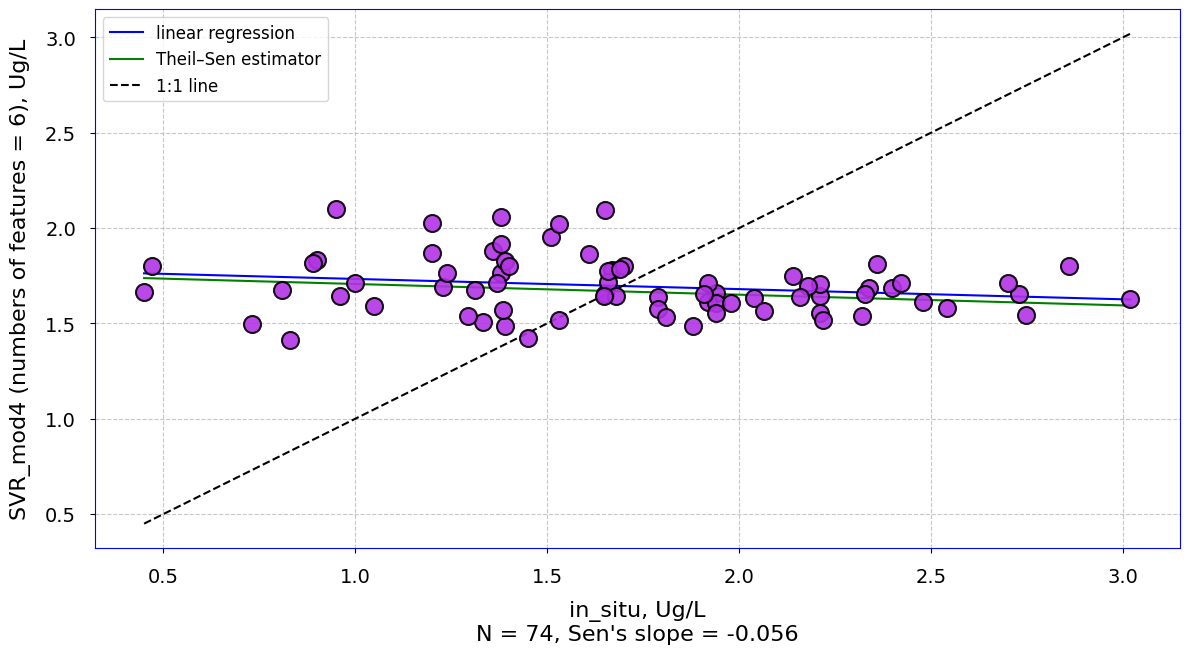

-0.6056755468844927
Cross-validated R^2: (0.03 + 0.00 + 0.00 + 0.00 + 0.42) / 5 = 0.09
Cross-validated Bias_log: (1.29 + 0.92 + 1.40 + 0.99 + 0.83) / 5 = 1.09
Cross-validated Bias: (-0.38 + 0.20 + -0.39 + 0.16 + 0.37) / 5 = -0.01
Cross-validated MAE_log: (1.30 + 1.28 + 1.63 + 1.39 + 1.47) / 5 = 1.41
Cross-validated MAE: (-0.40 + -0.42 + -0.71 + -0.52 + -0.70) / 5 = -0.55
Cross-validated RMSE: (-0.48 + -0.47 + -0.78 + -0.63 + -0.86) / 5 = -0.64
Cross-validated std: (-0.29 + -0.42 + -0.68 + -0.61 + -0.78) / 5 = -0.56
Cross-validated SS: (0.03 + 0.00 + -0.02 + 0.00 + -0.35) / 5 = -0.07
Cross-validated MAPE: (-0.33 + -0.25 + -0.70 + -0.41 + -0.34) / 5 = -0.41

Hyperparams (fold number = 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.1, 'svr_

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod4 (bands: Index(['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667'], dtype='object'))",0.091429,1.08689,-0.006258,1.414903,0.549238,0.644441,0.556699,-0.066627,0.406141,74


In [86]:
df_mod4_rrs6 = create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4')
nested_cv(df_mod4_rrs6, 'mod4', df_mod4_rrs6.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

---
Со всеми признаками

In [34]:
df_mod4_rrs6_extra = create_rrs_df_rgr(
    df_mod4, dict_stats_mod4, 'mod4', emp_algo_data=mod4_data)
# nested_cv(df_mod4_rrs6_extra, 'mod4', df_mod4_rrs6_extra.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

---
отбор признаков

* RF

In [36]:
rf = RandomForestRegressor(random_state=42)
rf.fit(df_mod4_rrs6_extra.iloc[:, :-1], df_mod4_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_mod4_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()
# nested_cv(df_mod4_rrs6_extra, 'mod4', top_features, param_grid, 'neg_root_mean_squared_error', SVR())

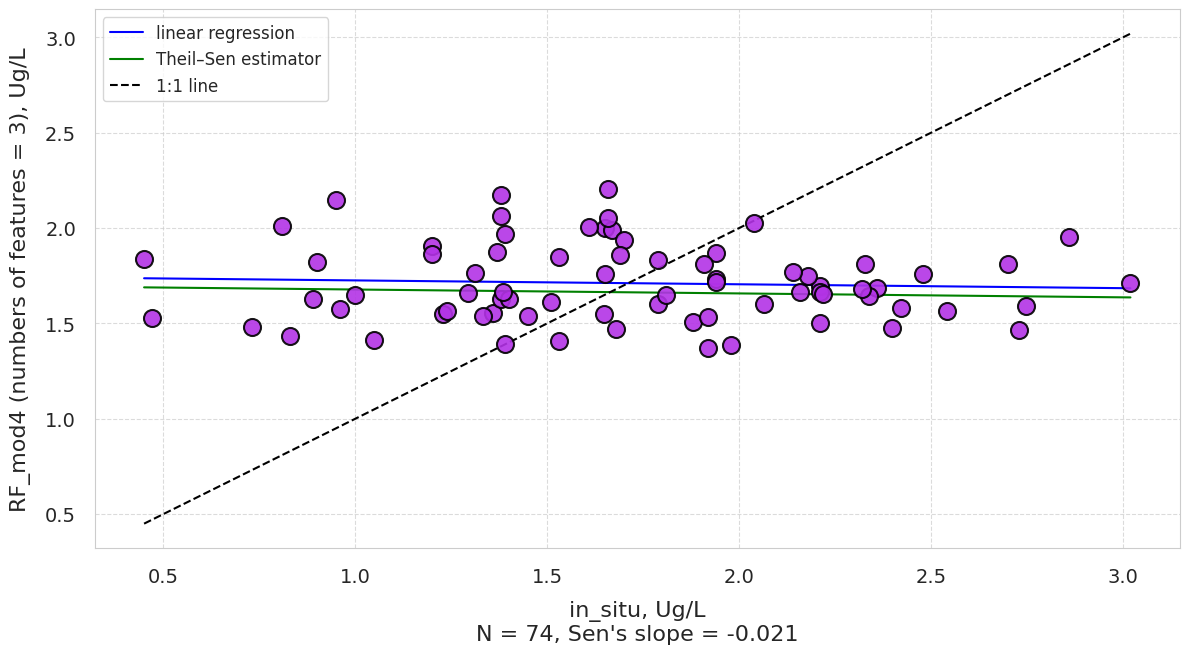

-0.5878965279491176
Cross-validated R^2: (0.01 + 0.37 + 0.01 + 0.00 + 0.01) / 5 = 0.08
Cross-validated Bias_log: (1.26 + 0.89 + 1.32 + 1.03 + 0.86) / 5 = 1.07
Cross-validated Bias: (-0.36 + 0.25 + -0.29 + 0.08 + 0.35) / 5 = 0.01
Cross-validated MAE_log: (1.31 + 1.23 + 1.63 + 1.41 + 1.33) / 5 = 1.38
Cross-validated MAE: (-0.43 + -0.36 + -0.70 + -0.54 + -0.55) / 5 = -0.52
Cross-validated RMSE: (-0.55 + -0.42 + -0.76 + -0.64 + -0.65) / 5 = -0.60
Cross-validated std: (-0.41 + -0.34 + -0.70 + -0.64 + -0.55) / 5 = -0.53
Cross-validated SS: (0.16 + 0.33 + 0.03 + 0.04 + -0.01) / 5 = 0.11
Cross-validated MAPE: (-0.35 + -0.20 + -0.64 + -0.44 + -0.26) / 5 = -0.38

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 32}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomfores

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod4 (bands: ['Rrs_531', 'Rrs_488', 'Rrs_555'])",0.079848,1.070869,0.005474,1.382272,0.515833,0.604461,0.527556,0.106843,0.37774,74


In [37]:
param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}
nested_cv(df_mod4_rrs6_extra, 'mod4', top_features, param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

* stepwise (анализ)

Вывод выбранных признаков
selected_features = [top_features[i] for i in sfs.get_support(indices=True)]
print("Выбранные признаки:", selected_features)

In [89]:
# sfs = SequentialFeatureSelector(SVR(), n_features_to_select='auto', direction='backward', scoring='neg_root_mean_squared_error', cv=5)
# X_selected = sfs.fit_transform(df_mod4_rrs6_extra.iloc[:, :-1], df_mod4_rrs6_extra['CHL'])
# current_feats = df_mod4_rrs6_extra.iloc[:, sfs.get_support(indices=True)].columns
# nested_cv(df_mod4_rrs6_extra, 'mod4',
#           current_feats, param_grid, scoring='neg_root_mean_squared_error')

* shap

In [90]:
# X_scaled = StandardScaler().fit_transform(df_mod4_rrs6_extra[current_feats])
# model = SVR().fit(X_scaled, df_mod4_rrs6_extra['CHL'])
# explainer = shap.KernelExplainer(model.predict, X_scaled)
# shap_values = explainer.shap_values(X_scaled)
# shap.summary_plot(shap_values, X_scaled, feature_names=current_feats)

'Rrs_488/Rrs_531',
           'Rrs_531/Rrs_488',
           'Rrs_443/Rrs_488',
            'Rrs_667'

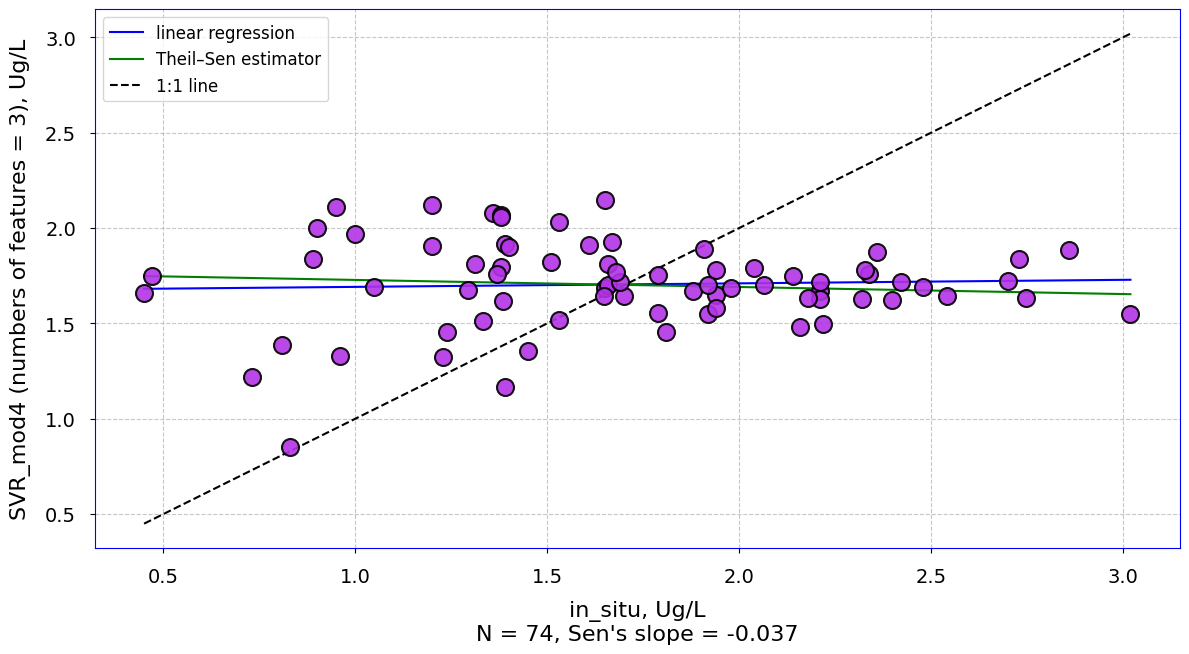

-0.5850285789166711
Cross-validated R^2: (0.07 + 0.15 + 0.02 + 0.02 + 0.01) / 5 = 0.05
Cross-validated Bias_log: (1.26 + 0.93 + 1.40 + 1.00 + 0.84) / 5 = 1.09
Cross-validated Bias: (-0.35 + 0.19 + -0.39 + 0.13 + 0.39) / 5 = -0.01
Cross-validated MAE_log: (1.30 + 1.27 + 1.64 + 1.43 + 1.33) / 5 = 1.40
Cross-validated MAE: (-0.40 + -0.41 + -0.72 + -0.56 + -0.56) / 5 = -0.53
Cross-validated RMSE: (-0.47 + -0.46 + -0.79 + -0.66 + -0.69) / 5 = -0.61
Cross-validated std: (-0.31 + -0.42 + -0.68 + -0.65 + -0.57) / 5 = -0.53
Cross-validated SS: (0.11 + 0.01 + -0.03 + -0.04 + -0.06) / 5 = -0.00
Cross-validated MAPE: (-0.32 + -0.24 + -0.70 + -0.45 + -0.25) / 5 = -0.39

Hyperparams (fold number = 1): {'svr__C': np.float64(5.878937969102394), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(69.12382328910758), 'svr__epsil

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod4 (bands: ['Rrs_531', 'Rrs_488', 'Rrs_555'])",0.053633,1.086044,-0.005651,1.395129,0.528887,0.614897,0.527762,-0.001177,0.39272,74


In [91]:
nested_cv(df_mod4_rrs6_extra, 'mod4', top_features, param_grid, 'neg_root_mean_squared_error', SVR(), )

#### mod1

In [38]:
df_mod1_rrs6 = create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1')
# nested_cv(df_mod1_rrs6, 'mod1', df_mod1_rrs6.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

---
все признаки

In [39]:
df_mod1_rrs6_extra = create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1', emp_algo_data=mod1_data)
# nested_cv(df_mod1_rrs6_extra, 'mod1', df_mod1_rrs6_extra.columns[:-1], param_grid, 'neg_root_mean_squared_error', SVR())

* лучшее: отбор случайным лесом

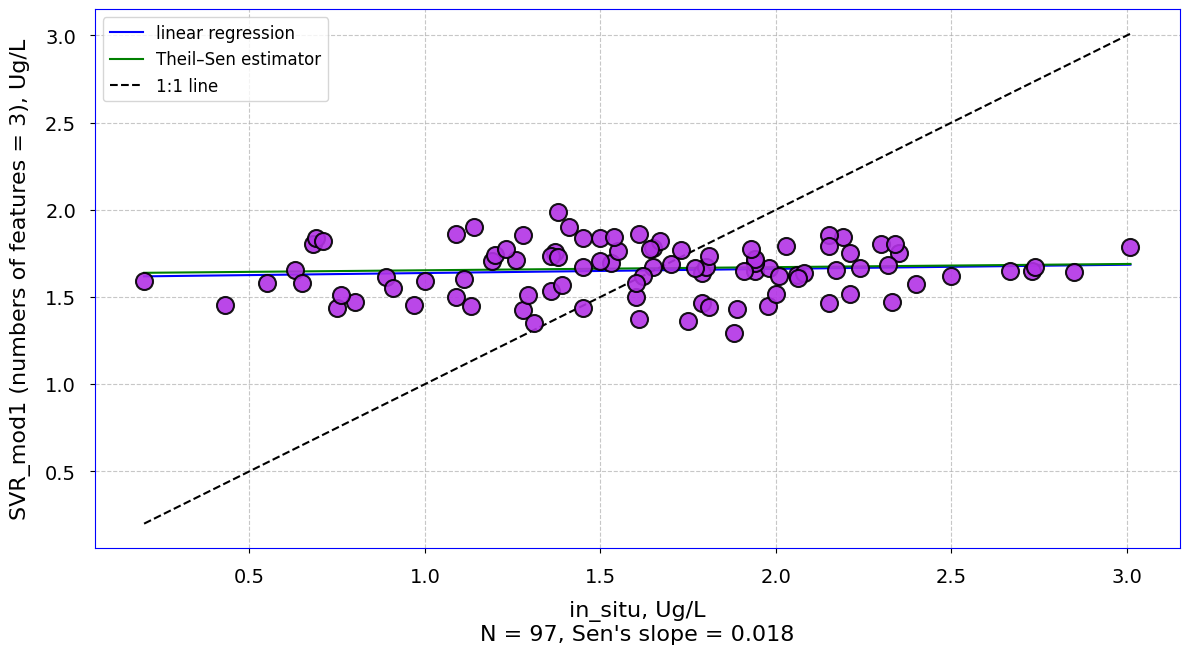

-0.5715752680206734
Cross-validated R^2: (0.02 + 0.05 + 0.12 + 0.13 + 0.19) / 5 = 0.10
Cross-validated Bias_log: (1.52 + 1.00 + 1.04 + 1.29 + 0.78) / 5 = 1.13
Cross-validated Bias: (-0.45 + 0.07 + 0.04 + -0.30 + 0.50) / 5 = -0.03
Cross-validated MAE_log: (1.65 + 1.26 + 1.32 + 1.39 + 1.35) / 5 = 1.40
Cross-validated MAE: (-0.59 + -0.37 + -0.44 + -0.44 + -0.56) / 5 = -0.48
Cross-validated RMSE: (-0.69 + -0.46 + -0.53 + -0.54 + -0.67) / 5 = -0.58
Cross-validated std: (-0.53 + -0.45 + -0.53 + -0.45 + -0.44) / 5 = -0.48
Cross-validated SS: (0.04 + 0.02 + 0.09 + 0.05 + 0.17) / 5 = 0.07
Cross-validated MAPE: (-0.92 + -0.27 + -0.32 + -0.46 + -0.26) / 5 = -0.44

Hyperparams (fold number = 1): {'svr__C': np.float64(0.9258747122872903), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(3.1748021039363987), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.014466792379488917)}
Hyperparams (fold number = 3): {'svr__C': np.float64(0.9258747

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod1 (bands: ['oc3_modis_1km', 'sur_refl_b12/sur_refl_b10', 'sur_refl_b11/sur_refl_b10'])",0.1017,1.127136,-0.030643,1.395103,0.481361,0.579099,0.481328,0.072331,0.444566,97


In [94]:
rf = RandomForestRegressor(random_state=42)
rf.fit(df_mod1_rrs6_extra.iloc[:, :-1], df_mod1_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_mod1_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()
nested_cv(df_mod1_rrs6_extra, 'mod1', top_features, param_grid, 'neg_root_mean_squared_error', SVR())

плохо

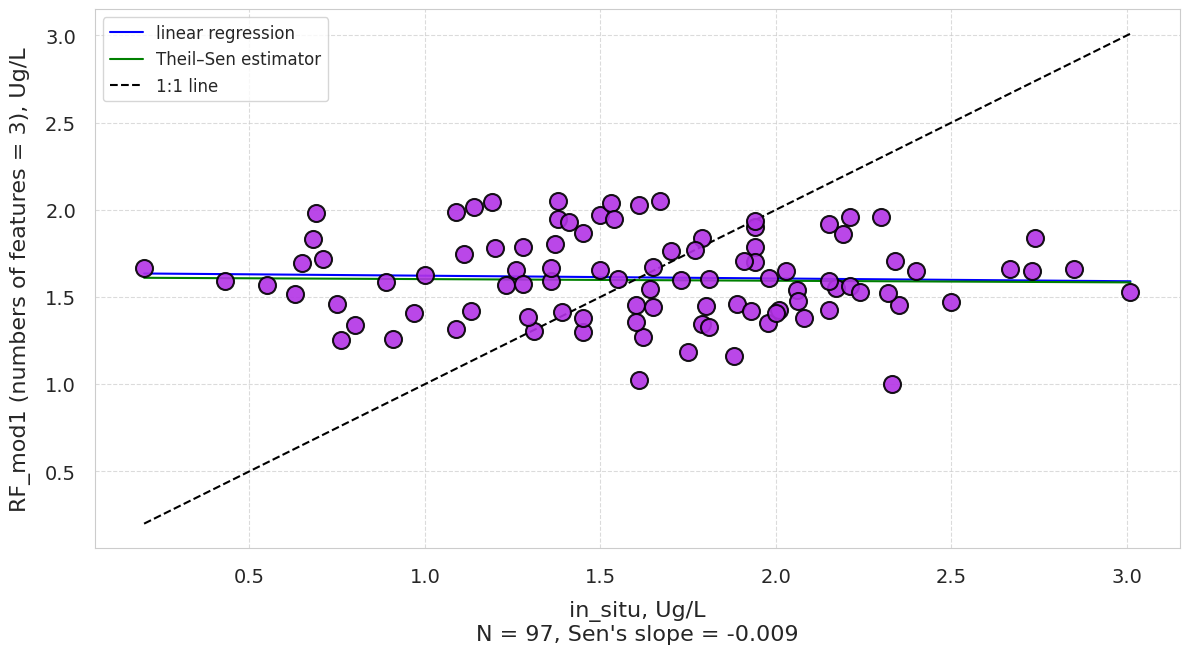

-0.6189242910780894
Cross-validated R^2: (0.01 + 0.01 + 0.04 + 0.00 + 0.03) / 5 = 0.02
Cross-validated Bias_log: (1.50 + 0.99 + 0.98 + 1.26 + 0.72) / 5 = 1.09
Cross-validated Bias: (-0.44 + 0.08 + 0.12 + -0.27 + 0.59) / 5 = 0.02
Cross-validated MAE_log: (1.65 + 1.29 + 1.35 + 1.44 + 1.48) / 5 = 1.44
Cross-validated MAE: (-0.60 + -0.41 + -0.47 + -0.49 + -0.68) / 5 = -0.53
Cross-validated RMSE: (-0.74 + -0.50 + -0.59 + -0.59 + -0.78) / 5 = -0.64
Cross-validated std: (-0.59 + -0.50 + -0.57 + -0.53 + -0.51) / 5 = -0.54
Cross-validated SS: (-0.01 + 0.05 + 0.04 + -0.15 + 0.14) / 5 = 0.01
Cross-validated MAPE: (-0.96 + -0.28 + -0.32 + -0.51 + -0.32) / 5 = -0.48

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 32}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomfore

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod1 (bands: ['oc3_modis_1km', 'sur_refl_b12/sur_refl_b10', 'sur_refl_b11/sur_refl_b10'])",0.01883,1.091061,0.016466,1.439575,0.529022,0.640248,0.540006,0.013647,0.480574,97


In [40]:
rf = RandomForestRegressor(random_state=42)
rf.fit(df_mod1_rrs6_extra.iloc[:, :-1], df_mod1_rrs6_extra['CHL'])
importance = pd.Series(rf.feature_importances_, index=df_mod1_rrs6_extra.iloc[:, :-1].columns).sort_values(ascending=False)
top_features = importance.head(3).index.tolist()
nested_cv(df_mod1_rrs6_extra, 'mod1', top_features, param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

### Bootstrap

Реализация на сенсорах MODIS алгоритма обучения SVM на 50 bootstrap выборках
* Чем уже ДИ, тем стабильнее модель. Широкий ДИ говорит о высокой вариабельности ошибки при разных выборках.

In [95]:
def caledonia(model, n_resamples: int, df_rrs: pd.DataFrame) -> list:
    """_summary_

    Args:
        model: not trained
        df_rrs (pd.DataFrame): columns[-2] == CHL

    Returns:
        pd.DataFrame: RMSE + Sen's slope (mean, confidence interaval, Kruskal test) for each models
    """

    df_result = pd.DataFrame()
    all_features = list(
        itertools.chain.from_iterable(itertools.combinations(
            df_rrs.columns[:-1], r) for r in range(1, 7))
    )
    np.random.seed(42)
    bootstrap_samples_keys = np.random.choice(
        df_rrs.index, (n_resamples, df_rrs.shape[0]), replace=True)
    rmse_dict, sens_slope_dict = dict(), dict()
    keys, number_of_bands_dict = dict(), dict()
    rmse_full_dict, sens_slope_full_dict = dict(), dict()
    rmse_ci_dict, sens_slope_ci_dict = dict(), dict()

    for combo_idx, combo in enumerate(all_features):
        rmse_bs_current, sens_slope_bs_current = np.zeros(
            n_resamples, dtype=np.float64), np.zeros(n_resamples, dtype=np.float64)
        number_of_bands_dict[combo_idx] = len(combo)

        # ---
        df_full = df_rrs.loc[:, combo].join(df_rrs['CHL'])
        X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
            df_full.iloc[:, :-1], df_full['CHL'],
            test_size=30, random_state=42
        )
        pipe_full = make_pipeline(StandardScaler(), model())
        pipe_full.fit(X_train_full, y_train_full)
        y_pred_full = pipe_full.predict(X_test_full)
        rmse_full_dict[combo_idx] = np.sqrt(
            mean_squared_error(y_test_full, y_pred_full))
        sens_slope_full_dict[combo_idx] = theilslopes(
            y_pred_full, y_test_full).slope
        # ---

        for i, indecies_current in enumerate(bootstrap_samples_keys):
            df_current = df_rrs.loc[indecies_current,
                                    combo].join(df_rrs['CHL'])
            X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
                df_current.iloc[:, :-1], df_current['CHL'], test_size=30, random_state=42)
            pipe = make_pipeline(StandardScaler(), model())
            pipe.fit(X_train_current, y_train_current)
            y_pred_current = pipe.predict(X_test_current)
            rmse_bs_current[i], sens_slope_bs_current[i] = np.sqrt(mean_squared_error(
                y_pred_current, y_test_current)), theilslopes(y_pred_current, y_test_current).slope
        
        rmse_ci_dict[combo_idx] = (_s1 := sorted(rmse_bs_current))[-2] - _s1[1]
        sens_slope_ci_dict[combo_idx] = (_s2 := sorted(sens_slope_bs_current))[-2] - _s2[1]
        rmse_dict[combo_idx], sens_slope_dict[combo_idx] = rmse_bs_current.mean(
        ), sens_slope_bs_current.mean()
        keys[combo_idx] = combo

    df_result['Number of used bands'] = number_of_bands_dict

    df_result['RMSE initial'] = rmse_full_dict
    df_result['RMSE mean'] = rmse_dict
    df_result['RMSE CI Length'] = rmse_ci_dict

    df_result['Sen\'s slope initial'] = sens_slope_full_dict
    df_result['Sen\'s slope mean'] = sens_slope_dict
    df_result['Sen\'s slope CI Length'] = sens_slope_ci_dict

    return df_result, keys

#### M4

In [96]:
bs_result_m4_art = caledonia(SVR, 50, create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4'))

In [97]:
bs_result_m4_art[0].describe()

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,3.047619,0.658618,0.579228,0.302862,0.049088,0.143765,0.496207
std,1.183605,0.024659,0.016509,0.043785,0.045605,0.050733,0.100447
min,1.000000,0.614091,0.544469,0.192582,-0.036883,0.022849,0.262602
25%,2.000000,0.641337,0.566543,0.273207,0.007227,0.120426,0.432855
50%,3.000000,0.654886,0.578358,0.306185,0.044616,0.154846,0.510037
75%,4.000000,0.673183,0.590313,0.337205,0.087062,0.176251,0.567309
max,6.000000,0.717532,0.612974,0.394793,0.158611,0.229899,0.673379


In [98]:
bs_result_m4_art[0].sort_values('RMSE mean').head(10) # 49, 38, 39, 

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
38,3,0.625665,0.544469,0.358491,0.158611,0.229899,0.643776
55,4,0.650559,0.550935,0.334452,0.112764,0.208446,0.559589
60,5,0.641953,0.552647,0.311254,0.108851,0.211680,0.574247
61,5,0.638004,0.556479,0.348458,0.118246,0.204694,0.583619
48,4,0.644661,0.556482,0.306437,0.121040,0.209762,0.623190
52,4,0.635100,0.557840,0.325298,0.110725,0.204936,0.579141
62,6,0.633435,0.559105,0.319737,0.096554,0.196578,0.582556
39,3,0.656956,0.559867,0.343717,0.055940,0.217170,0.627756
49,4,0.647150,0.560995,0.321209,0.042599,0.203457,0.565038
53,4,0.635185,0.563505,0.336218,0.074874,0.204284,0.603154


In [99]:
bs_result_m4_art[1][39], bs_result_m4_art[1][38], bs_result_m4_art[1][31], bs_result_m4_art[1][15], bs_result_m4_art[1][26]

(('Rrs_488', 'Rrs_555', 'Rrs_667'),
 ('Rrs_488', 'Rrs_531', 'Rrs_667'),
 ('Rrs_443', 'Rrs_488', 'Rrs_531'),
 ('Rrs_488', 'Rrs_531'),
 ('Rrs_412', 'Rrs_488', 'Rrs_555'))

In [100]:
bs_result_m4_art[1][32]

('Rrs_443', 'Rrs_488', 'Rrs_555')

---

* добро

In [101]:
bs_result_m4_art[0].sort_values('RMSE CI Length').loc[[38, 39, 49], :]

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
38,3,0.625665,0.544469,0.358491,0.158611,0.229899,0.643776
39,3,0.656956,0.559867,0.343717,0.055940,0.217170,0.627756
49,4,0.647150,0.560995,0.321209,0.042599,0.203457,0.565038


In [102]:
bs_result_m4_art[1][49]

('Rrs_412', 'Rrs_488', 'Rrs_555', 'Rrs_667')

---

#### M1

In [103]:
bs_result_m1_art = caledonia(SVR, 50, create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1'))

In [104]:
bs_result_m1_art[0].describe()

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,3.047619,0.492194,0.572439,0.276056,0.071565,0.077326,0.352968
std,1.183605,0.012196,0.004984,0.012193,0.028017,0.012421,0.055585
min,1.000000,0.472373,0.563655,0.236189,0.000914,0.028878,0.158860
25%,2.000000,0.483214,0.568211,0.267413,0.052028,0.072933,0.323969
50%,3.000000,0.488600,0.573755,0.278653,0.075177,0.079327,0.366076
75%,4.000000,0.498460,0.575846,0.283963,0.094249,0.086277,0.391152
max,6.000000,0.521442,0.588758,0.296065,0.124260,0.091864,0.435522


In [105]:
bs_result_m1_art[0].sort_values('RMSE CI Length').head(10)

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
2,1,0.506020,0.578011,0.236189,0.046621,0.053200,0.304807
0,1,0.488365,0.579918,0.248786,0.083407,0.056811,0.299219
10,2,0.491144,0.577319,0.255775,0.064536,0.079762,0.403589
5,1,0.516288,0.588758,0.257144,0.012821,0.028878,0.158860
14,2,0.489581,0.574018,0.257241,0.056871,0.070957,0.376830
6,2,0.483739,0.578398,0.257679,0.088294,0.074618,0.345303
11,2,0.477783,0.573763,0.260620,0.099918,0.072054,0.348363
26,3,0.485970,0.575600,0.260830,0.098132,0.086150,0.369916
7,2,0.487127,0.578478,0.262579,0.073208,0.075536,0.344869
42,4,0.484127,0.575164,0.262994,0.101743,0.083165,0.371444


In [106]:
bs_result_m1_art[0].sort_values('RMSE mean').head(10) # 10, 26

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
54,4,0.491280,0.563655,0.293787,0.070850,0.086985,0.347731
35,3,0.486805,0.563973,0.264029,0.075815,0.086132,0.374506
36,3,0.486783,0.564404,0.272680,0.084261,0.087319,0.353805
40,3,0.507826,0.564827,0.287679,0.032231,0.073289,0.266187
20,2,0.506948,0.565263,0.296065,0.030280,0.072577,0.263300
61,5,0.497807,0.565557,0.283212,0.061131,0.083868,0.357796
50,4,0.478595,0.566389,0.282312,0.103753,0.088248,0.337342
52,4,0.496588,0.566445,0.264971,0.048610,0.084945,0.372276
59,5,0.480868,0.566533,0.279350,0.094051,0.089129,0.419178
19,2,0.506635,0.566621,0.284571,0.030674,0.071130,0.277651


In [107]:
bs_result_m1_art[0].sort_values('RMSE CI Length').loc[[10, 26, 35], :]

,Number of used bands,RMSE initial,RMSE mean,RMSE CI Length,Sen's slope initial,Sen's slope mean,Sen's slope CI Length
10,2,0.491144,0.577319,0.255775,0.064536,0.079762,0.403589
26,3,0.485970,0.575600,0.260830,0.098132,0.086150,0.369916
35,3,0.486805,0.563973,0.264029,0.075815,0.086132,0.374506


### SVR (best bands)

#### M4

38, 39, 49

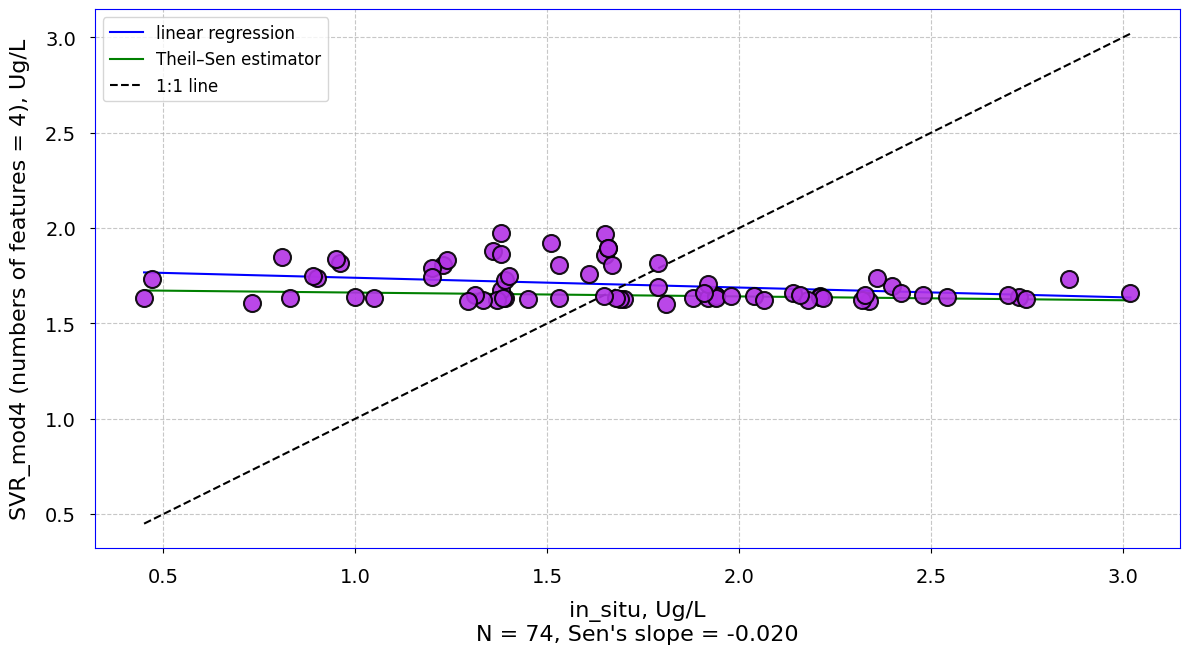

-0.5980643266592374
Cross-validated R^2: (0.02 + 0.00 + 0.00 + 0.01 + 0.52) / 5 = 0.11
Cross-validated Bias_log: (1.30 + 0.92 + 1.40 + 0.99 + 0.84) / 5 = 1.09
Cross-validated Bias: (-0.40 + 0.20 + -0.38 + 0.16 + 0.34) / 5 = -0.01
Cross-validated MAE_log: (1.31 + 1.27 + 1.63 + 1.39 + 1.51) / 5 = 1.42
Cross-validated MAE: (-0.41 + -0.41 + -0.70 + -0.51 + -0.77) / 5 = -0.56
Cross-validated RMSE: (-0.49 + -0.47 + -0.77 + -0.63 + -0.92) / 5 = -0.66
Cross-validated std: (-0.29 + -0.42 + -0.67 + -0.61 + -0.86) / 5 = -0.57
Cross-validated SS: (-0.01 + 0.01 + -0.01 + 0.00 + -0.45) / 5 = -0.09
Cross-validated MAPE: (-0.34 + -0.24 + -0.69 + -0.41 + -0.38) / 5 = -0.41

Hyperparams (fold number = 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(1.7144879657061456), 'svr__epsilon'

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod4 (bands: ('Rrs_412', 'Rrs_488', 'Rrs_555', 'Rrs_667'))",0.111855,1.090358,-0.014719,1.424043,0.561832,0.656044,0.570428,-0.091854,0.414715,74


In [108]:
nested_cv(create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4'), 'mod4', bs_result_m4_art[1][49], param_grid, 'neg_root_mean_squared_error', SVR())

* лучшее

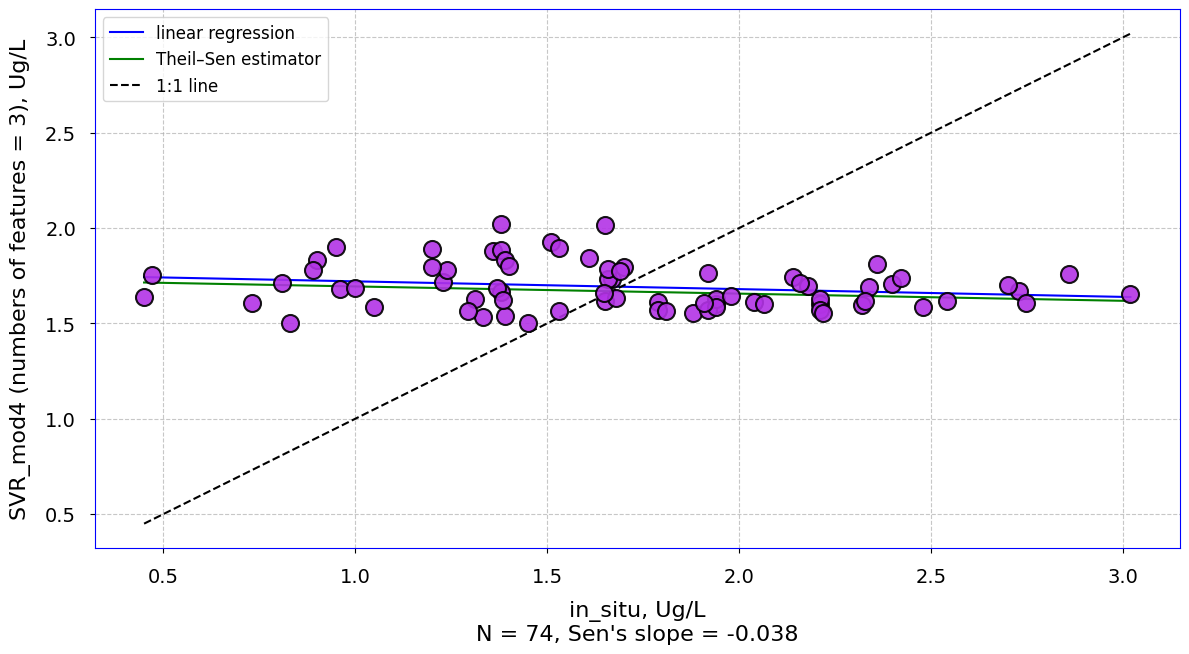

-0.5943265444535639
Cross-validated R^2: (0.00 + 0.07 + 0.01 + 0.04 + 0.11) / 5 = 0.05
Cross-validated Bias_log: (1.25 + 0.93 + 1.37 + 1.09 + 0.84) / 5 = 1.10
Cross-validated Bias: (-0.33 + 0.19 + -0.35 + -0.03 + 0.39) / 5 = -0.02
Cross-validated MAE_log: (1.30 + 1.27 + 1.63 + 1.41 + 1.34) / 5 = 1.39
Cross-validated MAE: (-0.39 + -0.41 + -0.71 + -0.54 + -0.56) / 5 = -0.52
Cross-validated RMSE: (-0.46 + -0.46 + -0.77 + -0.62 + -0.67) / 5 = -0.60
Cross-validated std: (-0.33 + -0.42 + -0.69 + -0.62 + -0.54) / 5 = -0.52
Cross-validated SS: (-0.11 + 0.01 + -0.02 + 0.08 + 0.01) / 5 = -0.01
Cross-validated MAPE: (-0.32 + -0.24 + -0.68 + -0.45 + -0.26) / 5 = -0.39

Hyperparams (fold number = 1): {'svr__C': np.float64(1.7144879657061456), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(10.886320001395017), 'svr__epsi

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod4 (bands: ('Rrs_488', 'Rrs_531', 'Rrs_667'))",0.045259,1.095026,-0.023612,1.390582,0.522742,0.597729,0.521417,-0.006631,0.389228,74


In [109]:
nested_cv(create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4'), 'mod4', bs_result_m4_art[1][38], param_grid, 'neg_root_mean_squared_error', SVR())

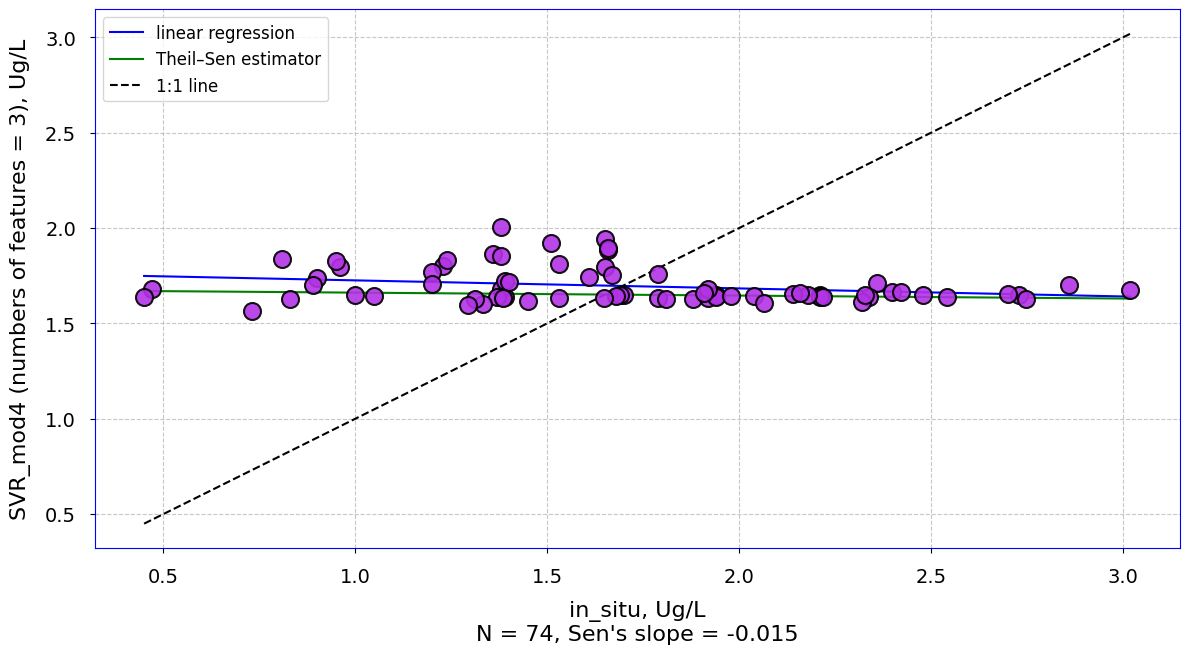

-0.5928013820501975
Cross-validated R^2: (0.00 + 0.14 + 0.02 + 0.00 + 0.28) / 5 = 0.09
Cross-validated Bias_log: (1.28 + 0.93 + 1.41 + 1.09 + 0.84) / 5 = 1.11
Cross-validated Bias: (-0.36 + 0.19 + -0.40 + -0.02 + 0.38) / 5 = -0.04
Cross-validated MAE_log: (1.29 + 1.27 + 1.65 + 1.43 + 1.34) / 5 = 1.40
Cross-validated MAE: (-0.38 + -0.41 + -0.73 + -0.57 + -0.56) / 5 = -0.53
Cross-validated RMSE: (-0.47 + -0.46 + -0.80 + -0.66 + -0.66) / 5 = -0.61
Cross-validated std: (-0.30 + -0.42 + -0.69 + -0.66 + -0.54) / 5 = -0.52
Cross-validated SS: (-0.03 + 0.01 + 0.00 + -0.01 + 0.01) / 5 = -0.00
Cross-validated MAPE: (-0.32 + -0.24 + -0.71 + -0.47 + -0.26) / 5 = -0.40

Hyperparams (fold number = 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.0078125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(20.158736798317967), 'svr__epsilon': 0.1, 'svr

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod4 (bands: ('Rrs_488', 'Rrs_555', 'Rrs_667'))",0.088569,1.109293,-0.0418,1.396123,0.530356,0.6092,0.51992,-0.004478,0.400148,74


In [110]:
nested_cv(create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4'), 'mod4', bs_result_m4_art[1][39], param_grid, 'neg_root_mean_squared_error', SVR())

#### M1

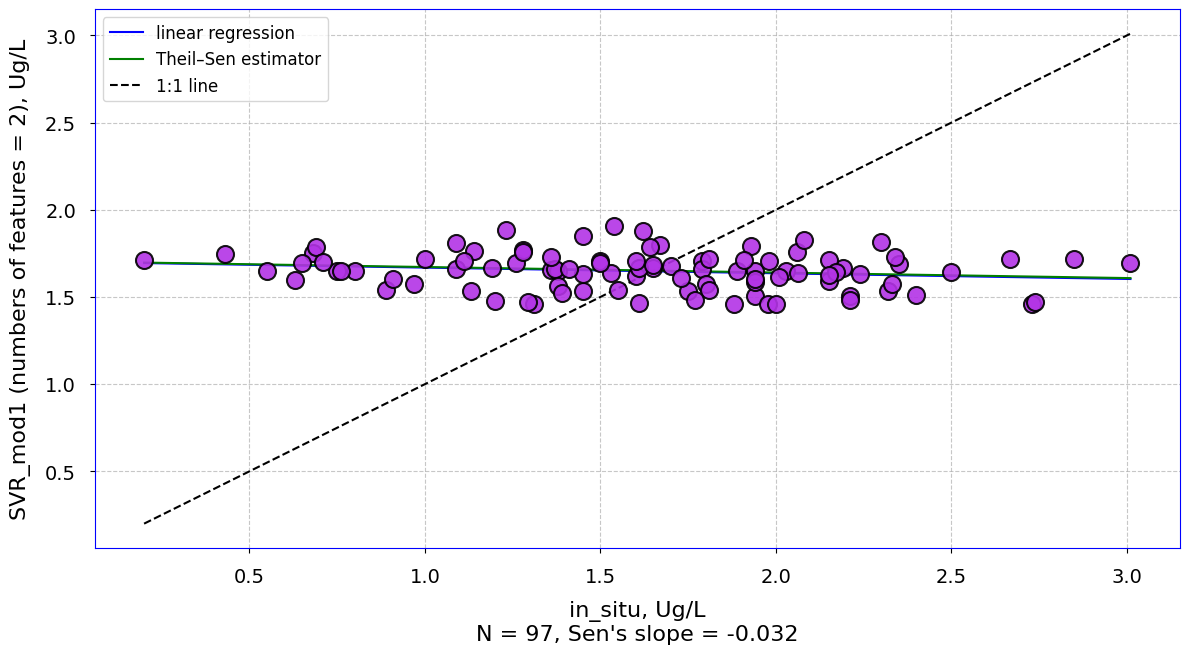

-0.5946381072942382
Cross-validated R^2: (0.15 + 0.03 + 0.00 + 0.11 + 0.03) / 5 = 0.07
Cross-validated Bias_log: (1.50 + 0.97 + 1.06 + 1.31 + 0.76) / 5 = 1.12
Cross-validated Bias: (-0.42 + 0.11 + -0.02 + -0.32 + 0.53) / 5 = -0.02
Cross-validated MAE_log: (1.61 + 1.28 + 1.38 + 1.48 + 1.39) / 5 = 1.43
Cross-validated MAE: (-0.55 + -0.39 + -0.52 + -0.54 + -0.61) / 5 = -0.52
Cross-validated RMSE: (-0.68 + -0.47 + -0.65 + -0.65 + -0.71) / 5 = -0.63
Cross-validated std: (-0.53 + -0.46 + -0.65 + -0.56 + -0.48) / 5 = -0.54
Cross-validated SS: (-0.03 + 0.06 + -0.03 + -0.16 + 0.08) / 5 = -0.02
Cross-validated MAPE: (-0.91 + -0.27 + -0.39 + -0.58 + -0.28) / 5 = -0.49

Hyperparams (fold number = 1): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.014466792379488917)}
Hyperparams (fold number = 2): {'svr__C': np.float64(10.886320001395017), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.03645403248675365)}
Hyperparams (fold number = 3): {'svr__C': np.float64(20.1587367

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod1 (bands: ('sur_refl_b08', 'sur_refl_b13'))",0.065405,1.122524,-0.024126,1.428267,0.523313,0.63348,0.536694,-0.015331,0.485415,97


In [111]:
nested_cv(create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1'), 'mod1',
          bs_result_m1_art[1][10], param_grid, 'neg_root_mean_squared_error', SVR())

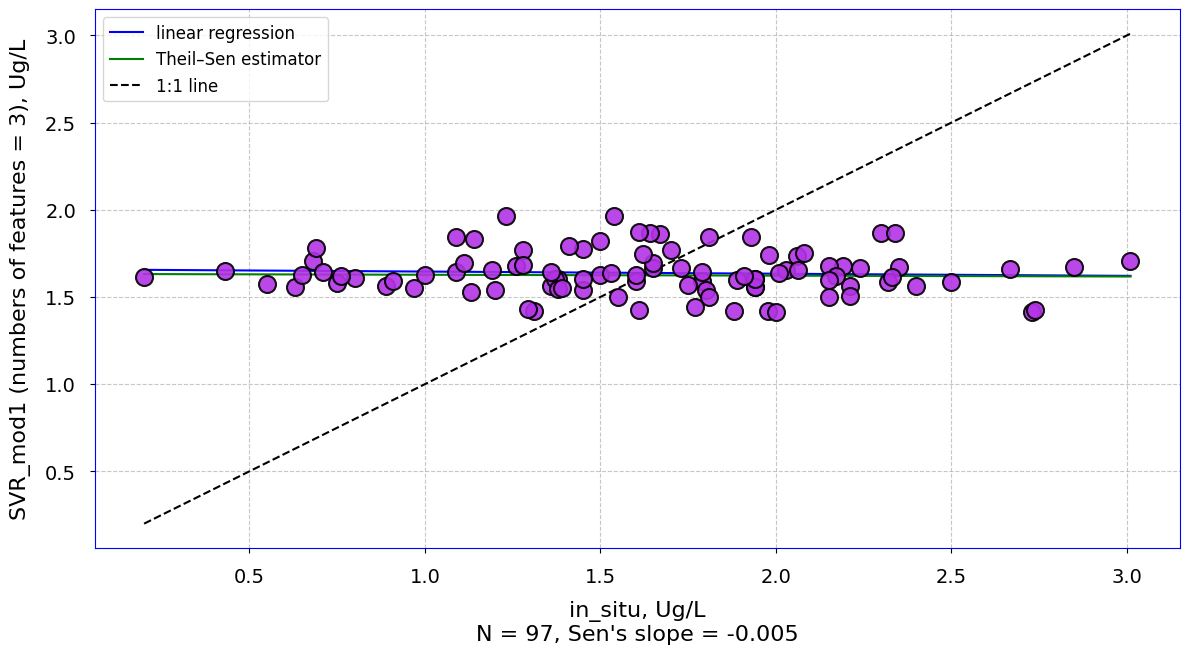

-0.5865457801322375
Cross-validated R^2: (0.02 + 0.13 + 0.10 + 0.01 + 0.03) / 5 = 0.06
Cross-validated Bias_log: (1.53 + 0.98 + 1.04 + 1.33 + 0.76) / 5 = 1.13
Cross-validated Bias: (-0.46 + 0.11 + 0.04 + -0.35 + 0.53) / 5 = -0.03
Cross-validated MAE_log: (1.62 + 1.27 + 1.32 + 1.47 + 1.39) / 5 = 1.42
Cross-validated MAE: (-0.56 + -0.38 + -0.44 + -0.53 + -0.61) / 5 = -0.51
Cross-validated RMSE: (-0.70 + -0.46 + -0.55 + -0.64 + -0.71) / 5 = -0.61
Cross-validated std: (-0.53 + -0.44 + -0.55 + -0.53 + -0.48) / 5 = -0.51
Cross-validated SS: (0.03 + 0.06 + 0.04 + -0.11 + 0.07) / 5 = 0.02
Cross-validated MAPE: (-0.91 + -0.26 + -0.32 + -0.56 + -0.28) / 5 = -0.47

Hyperparams (fold number = 1): {'svr__C': np.float64(5.878937969102394), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.125)}
Hyperparams (fold number = 2): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.09185840576722491)}
Hyperparams (fold number = 3): {'svr__C': np.float64(0.5), 'svr__epsilon': 0.01, '

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod1 (bands: ('sur_refl_b08', 'sur_refl_b10', 'sur_refl_b12'))",0.057495,1.129798,-0.029038,1.415008,0.506585,0.611998,0.505909,0.017912,0.466694,97


In [112]:
nested_cv(create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1'), 'mod1',
          bs_result_m1_art[1][26], param_grid, 'neg_root_mean_squared_error', SVR())

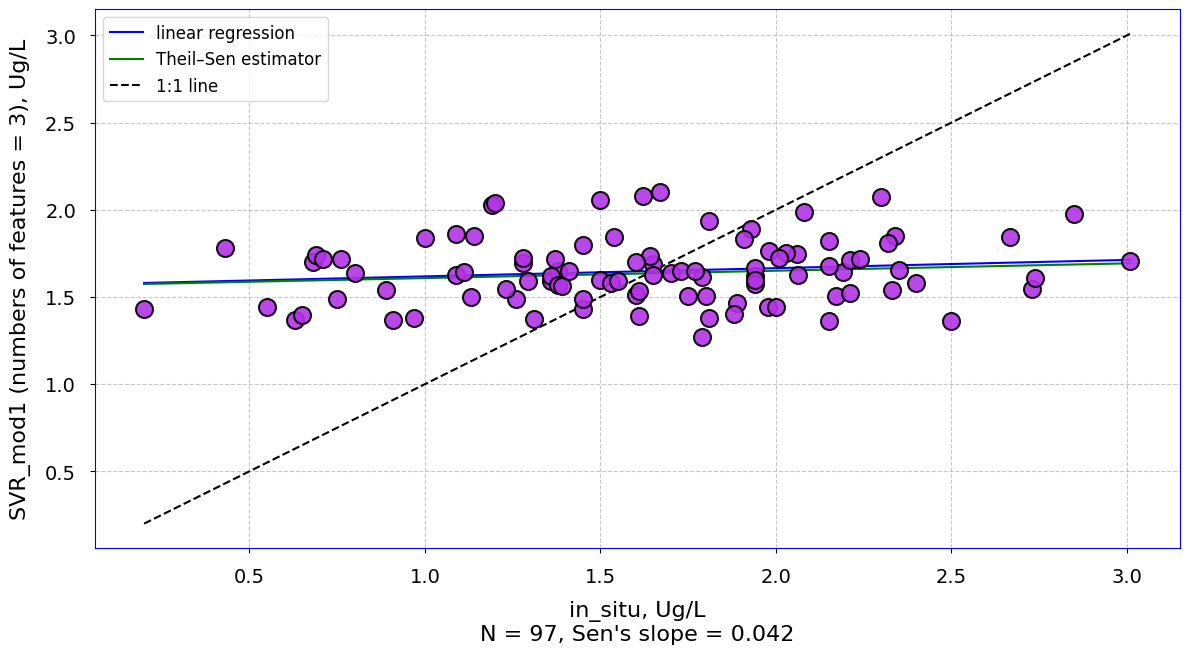

-0.5715344355639561
Cross-validated R^2: (0.02 + 0.19 + 0.03 + 0.01 + 0.07) / 5 = 0.06
Cross-validated Bias_log: (1.50 + 0.97 + 1.04 + 1.30 + 0.78) / 5 = 1.12
Cross-validated Bias: (-0.43 + 0.12 + 0.03 + -0.33 + 0.50) / 5 = -0.02
Cross-validated MAE_log: (1.65 + 1.25 + 1.34 + 1.48 + 1.36) / 5 = 1.42
Cross-validated MAE: (-0.59 + -0.36 + -0.47 + -0.54 + -0.58) / 5 = -0.51
Cross-validated RMSE: (-0.69 + -0.44 + -0.57 + -0.68 + -0.69) / 5 = -0.61
Cross-validated std: (-0.54 + -0.43 + -0.57 + -0.59 + -0.47) / 5 = -0.52
Cross-validated SS: (-0.03 + 0.14 + 0.06 + -0.05 + 0.07) / 5 = 0.04
Cross-validated MAPE: (-0.89 + -0.24 + -0.34 + -0.57 + -0.26) / 5 = -0.46

Hyperparams (fold number = 1): {'svr__C': np.float64(128.0), 'svr__epsilon': 0.1, 'svr__gamma': np.float64(0.010631171876362321)}
Hyperparams (fold number = 2): {'svr__C': np.float64(3.1748021039363987), 'svr__epsilon': 0.01, 'svr__gamma': np.float64(0.125)}
Hyperparams (fold number = 3): {'svr__C': np.float64(3.1748021039363987), 'sv

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"SVR_mod1 (bands: ('sur_refl_b09', 'sur_refl_b11', 'sur_refl_b13'))",0.064261,1.116836,-0.020827,1.41777,0.507449,0.612747,0.51937,0.037728,0.460911,97


In [113]:
nested_cv(create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1'), 'mod1',
          bs_result_m1_art[1][35], param_grid, 'neg_root_mean_squared_error', SVR())

# RFR

In [114]:
param_grid_rf = {
    'randomforestregressor__n_estimators': [32, 64, 128],
    'randomforestregressor__max_depth': [5, 10, 15],
    'randomforestregressor__max_features': ['sqrt', 0.3],
    'randomforestregressor__min_samples_split': [2, 5]
}

## M4

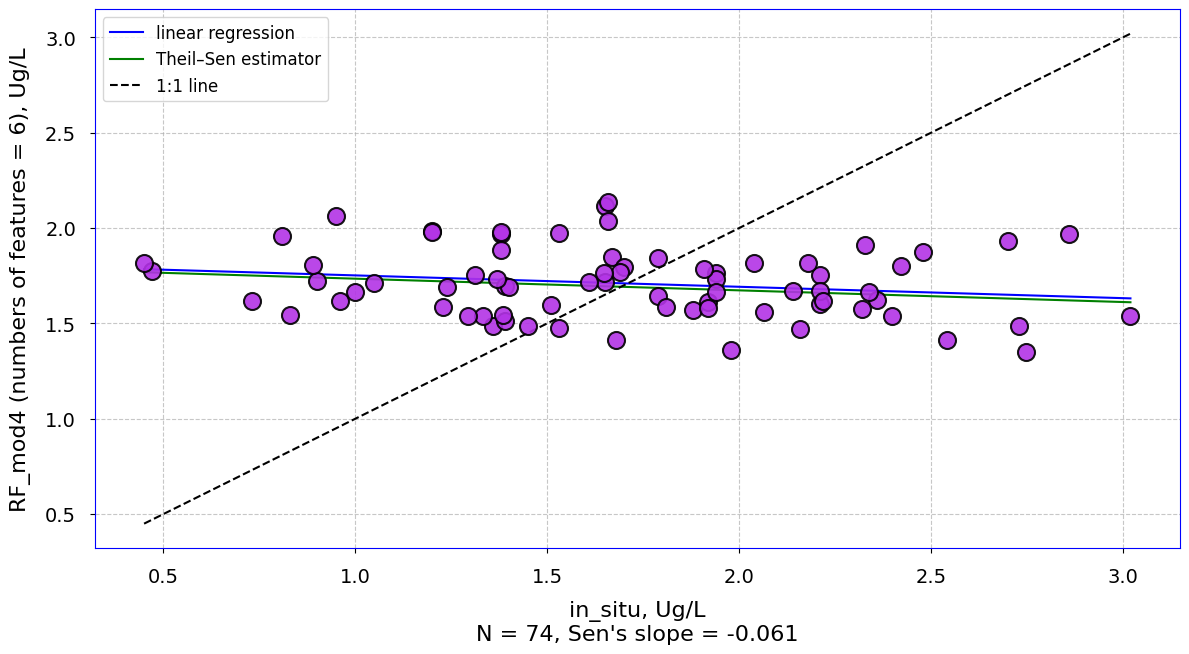

-0.6030937318663672
Cross-validated R^2: (0.04 + 0.14 + 0.01 + 0.00 + 0.08) / 5 = 0.06
Cross-validated Bias_log: (1.26 + 0.93 + 1.36 + 1.07 + 0.83) / 5 = 1.09
Cross-validated Bias: (-0.34 + 0.17 + -0.33 + 0.01 + 0.40) / 5 = -0.02
Cross-validated MAE_log: (1.29 + 1.24 + 1.64 + 1.41 + 1.38) / 5 = 1.39
Cross-validated MAE: (-0.39 + -0.37 + -0.71 + -0.53 + -0.61) / 5 = -0.52
Cross-validated RMSE: (-0.47 + -0.43 + -0.78 + -0.64 + -0.74) / 5 = -0.61
Cross-validated std: (-0.32 + -0.39 + -0.71 + -0.64 + -0.62) / 5 = -0.54
Cross-validated SS: (0.26 + 0.18 + -0.07 + -0.01 + -0.10) / 5 = 0.05
Cross-validated MAPE: (-0.32 + -0.22 + -0.69 + -0.46 + -0.28) / 5 = -0.39

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 64}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'randomforestre

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod4 (bands: Index(['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667'], dtype='object'))",0.055719,1.089108,-0.016986,1.392014,0.522953,0.61098,0.535206,0.052098,0.394975,74


In [115]:
_ = create_rrs_df_rgr(df_mod4, dict_stats_mod4, 'mod4')
nested_cv(_, 'mod4', _.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

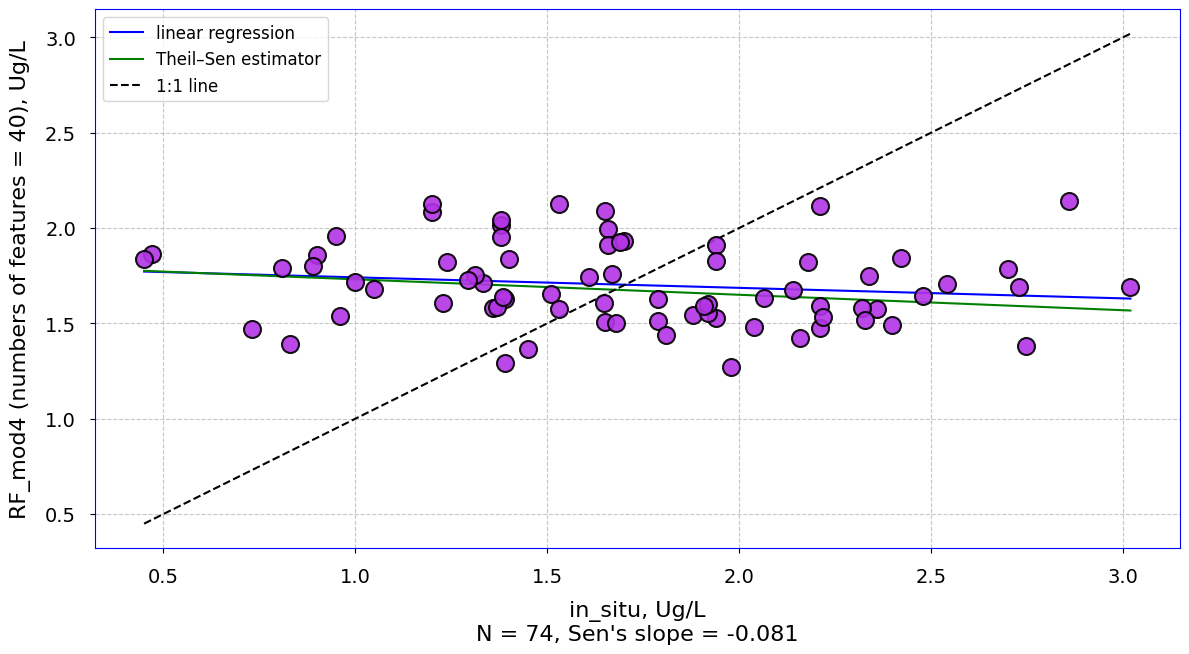

-0.6050400636893745
Cross-validated R^2: (0.00 + 0.10 + 0.01 + 0.02 + 0.10) / 5 = 0.05
Cross-validated Bias_log: (1.26 + 0.96 + 1.36 + 1.03 + 0.82) / 5 = 1.09
Cross-validated Bias: (-0.35 + 0.11 + -0.34 + 0.09 + 0.43) / 5 = -0.01
Cross-validated MAE_log: (1.33 + 1.21 + 1.66 + 1.41 + 1.41) / 5 = 1.40
Cross-validated MAE: (-0.43 + -0.32 + -0.73 + -0.53 + -0.64) / 5 = -0.53
Cross-validated RMSE: (-0.49 + -0.43 + -0.81 + -0.64 + -0.74) / 5 = -0.62
Cross-validated std: (-0.35 + -0.42 + -0.73 + -0.63 + -0.60) / 5 = -0.54
Cross-validated SS: (0.06 + 0.17 + -0.08 + 0.01 + -0.05) / 5 = 0.02
Cross-validated MAPE: (-0.35 + -0.20 + -0.70 + -0.45 + -0.30) / 5 = -0.40

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__n_estimators': 128}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.3, 'randomforestr

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod4 (bands: Index(['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667',\n 'Rrs_412/Rrs_443', 'Rrs_412/Rrs_488', 'Rrs_412/Rrs_531',\n 'Rrs_412/Rrs_555', 'Rrs_412/Rrs_667', 'Rrs_443/Rrs_412',\n 'Rrs_443/Rrs_488', 'Rrs_443/Rrs_531', 'Rrs_443/Rrs_555',\n 'Rrs_443/Rrs_667', 'Rrs_488/Rrs_412', 'Rrs_488/Rrs_443',\n 'Rrs_488/Rrs_531', 'Rrs_488/Rrs_555', 'Rrs_488/Rrs_667',\n 'Rrs_531/Rrs_412', 'Rrs_531/Rrs_443', 'Rrs_531/Rrs_488',\n 'Rrs_531/Rrs_555', 'Rrs_531/Rrs_667', 'Rrs_555/Rrs_412',\n 'Rrs_555/Rrs_443', 'Rrs_555/Rrs_488', 'Rrs_555/Rrs_531',\n 'Rrs_555/Rrs_667', 'Rrs_667/Rrs_412', 'Rrs_667/Rrs_443',\n 'Rrs_667/Rrs_488', 'Rrs_667/Rrs_531', 'Rrs_667/Rrs_555',\n 'oc6_modis_4km', 'oc5_modis_4km', 'oc4_modis_4km', 'oc3_modis_4km'],\n dtype='object'))",0.046501,1.085565,-0.012144,1.40206,0.531601,0.620632,0.54447,0.022424,0.399509,74


In [116]:
__ = create_rrs_df_rgr(
    df_mod4, dict_stats_mod4, 'mod4', emp_algo_data=mod4_data)
nested_cv(__, 'mod4', __.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

## M1

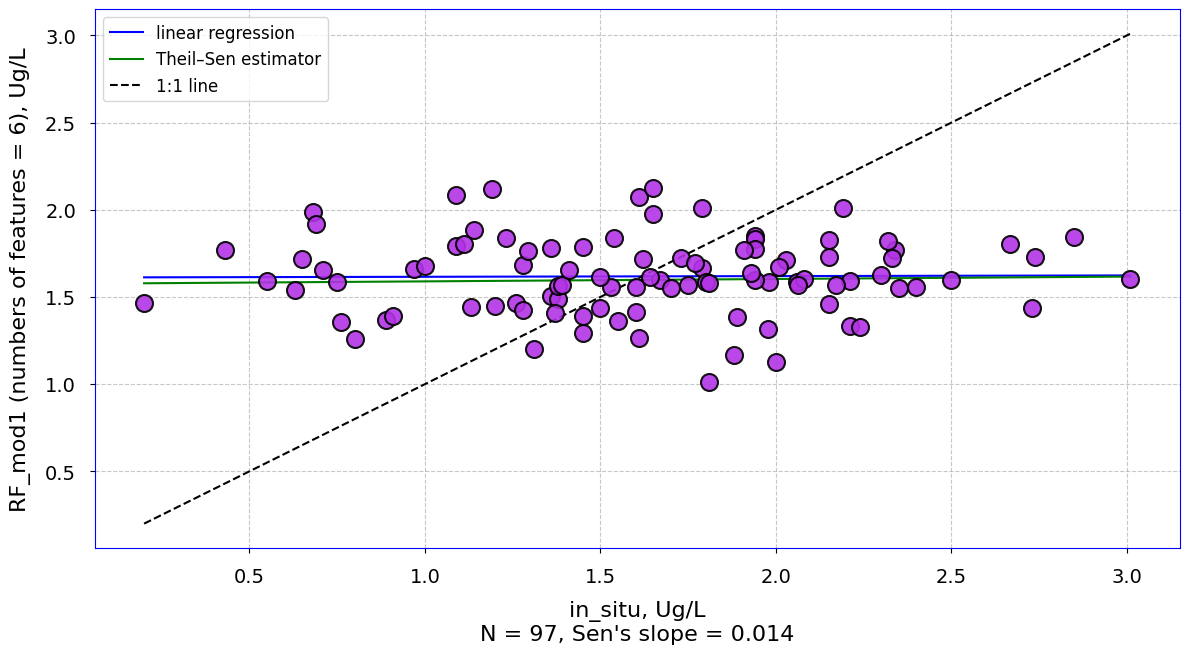

-0.5883063537838499
Cross-validated R^2: (0.03 + 0.09 + 0.01 + 0.03 + 0.03) / 5 = 0.04
Cross-validated Bias_log: (1.52 + 0.95 + 0.99 + 1.25 + 0.75) / 5 = 1.09
Cross-validated Bias: (-0.46 + 0.15 + 0.11 + -0.25 + 0.53) / 5 = 0.02
Cross-validated MAE_log: (1.58 + 1.27 + 1.36 + 1.39 + 1.44) / 5 = 1.41
Cross-validated MAE: (-0.53 + -0.38 + -0.48 + -0.43 + -0.65) / 5 = -0.49
Cross-validated RMSE: (-0.69 + -0.47 + -0.58 + -0.53 + -0.73) / 5 = -0.60
Cross-validated std: (-0.51 + -0.44 + -0.57 + -0.47 + -0.50) / 5 = -0.50
Cross-validated SS: (0.09 + 0.07 + 0.04 + 0.07 + 0.11) / 5 = 0.08
Cross-validated MAPE: (-0.88 + -0.25 + -0.34 + -0.46 + -0.31) / 5 = -0.45

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 128}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.3, 'randomforestregre

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod1 (bands: Index(['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11',\n 'sur_refl_b12', 'sur_refl_b13'],\n dtype='object'))",0.037263,1.093014,0.017542,1.405711,0.490911,0.59828,0.497968,0.076891,0.448517,97


In [117]:
_ = create_rrs_df_rgr(df_mod1, dict_stats_mod1, 'mod1')
nested_cv(_, 'mod1', _.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

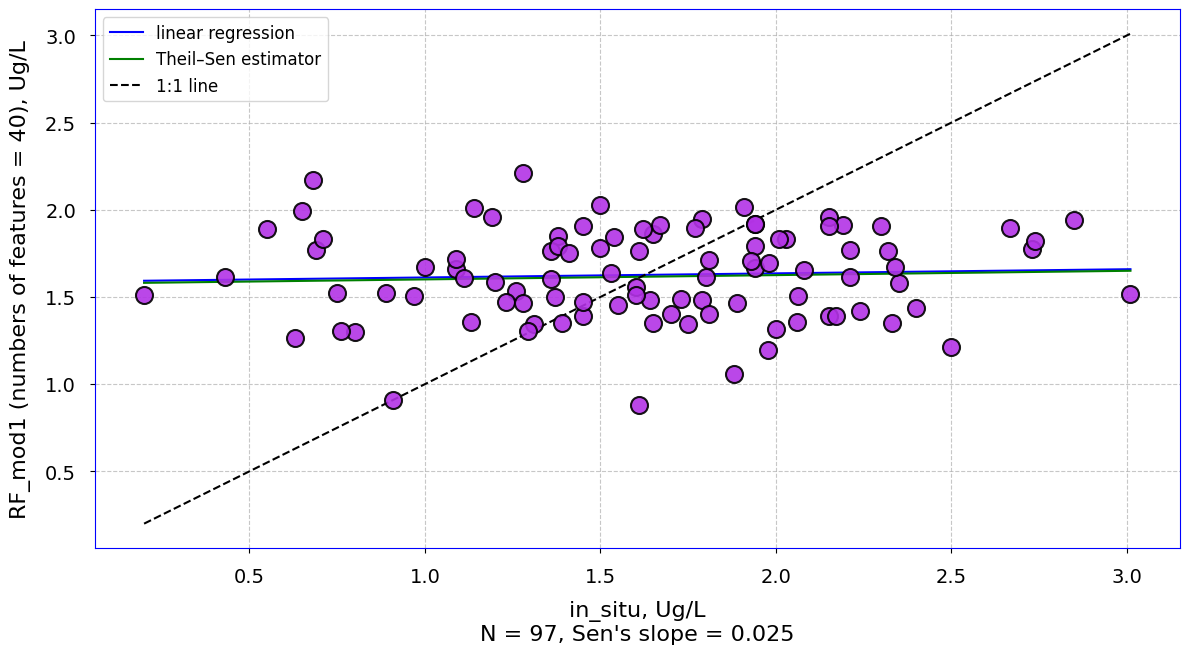

-0.5848779025732523
Cross-validated R^2: (0.01 + 0.08 + 0.03 + 0.00 + 0.10) / 5 = 0.04
Cross-validated Bias_log: (1.51 + 0.99 + 0.98 + 1.23 + 0.76) / 5 = 1.09
Cross-validated Bias: (-0.44 + 0.08 + 0.11 + -0.23 + 0.52) / 5 = 0.01
Cross-validated MAE_log: (1.62 + 1.24 + 1.34 + 1.41 + 1.41) / 5 = 1.41
Cross-validated MAE: (-0.57 + -0.34 + -0.47 + -0.46 + -0.61) / 5 = -0.49
Cross-validated RMSE: (-0.70 + -0.47 + -0.60 + -0.59 + -0.70) / 5 = -0.61
Cross-validated std: (-0.54 + -0.46 + -0.59 + -0.54 + -0.47) / 5 = -0.52
Cross-validated SS: (0.02 + 0.10 + 0.02 + -0.04 + 0.29) / 5 = 0.08
Cross-validated MAPE: (-0.91 + -0.23 + -0.32 + -0.47 + -0.29) / 5 = -0.44

Hyperparams (fold number = 1): {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 64}
Hyperparams (fold number = 2): {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'sqrt', 'randomfore

,R2,Bias_log,Bias,MAE_log,MAE,RMSE,std,SS,MAPE,N
"RF_mod1 (bands: Index(['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11',\n 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b08/sur_refl_b09',\n 'sur_refl_b08/sur_refl_b10', 'sur_refl_b08/sur_refl_b11',\n 'sur_refl_b08/sur_refl_b12', 'sur_refl_b08/sur_refl_b13',\n 'sur_refl_b09/sur_refl_b08', 'sur_refl_b09/sur_refl_b10',\n 'sur_refl_b09/sur_refl_b11', 'sur_refl_b09/sur_refl_b12',\n 'sur_refl_b09/sur_refl_b13', 'sur_refl_b10/sur_refl_b08',\n 'sur_refl_b10/sur_refl_b09', 'sur_refl_b10/sur_refl_b11',\n 'sur_refl_b10/sur_refl_b12', 'sur_refl_b10/sur_refl_b13',\n 'sur_refl_b11/sur_refl_b08', 'sur_refl_b11/sur_refl_b09',\n 'sur_refl_b11/sur_refl_b10', 'sur_refl_b11/sur_refl_b12',\n 'sur_refl_b11/sur_refl_b13', 'sur_refl_b12/sur_refl_b08',\n 'sur_refl_b12/sur_refl_b09', 'sur_refl_b12/sur_refl_b10',\n 'sur_refl_b12/sur_refl_b11', 'sur_refl_b12/sur_refl_b13',\n 'sur_refl_b13/sur_refl_b08', 'sur_refl_b13/sur_refl_b09',\n 'sur_refl_b13/sur_refl_b10', 'sur_refl_b13/sur_refl_b11',\n 'sur_refl_b13/sur_refl_b12', 'oc6_modis_1km', 'oc5_modis_1km',\n 'oc4_modis_1km', 'oc3_modis_1km'],\n dtype='object'))",0.04413,1.091818,0.008429,1.405811,0.489133,0.610805,0.520832,0.07675,0.444704,97


In [118]:
__ = create_rrs_df_rgr(
    df_mod1, dict_stats_mod1, 'mod1', emp_algo_data=mod1_data)
nested_cv(__, 'mod1', __.columns[:-1], param_grid_rf, 'neg_root_mean_squared_error', RandomForestRegressor())

# Classifier

все данные

Train Accuracy: 0.9696969696969697       Test Accuracy: 0.9


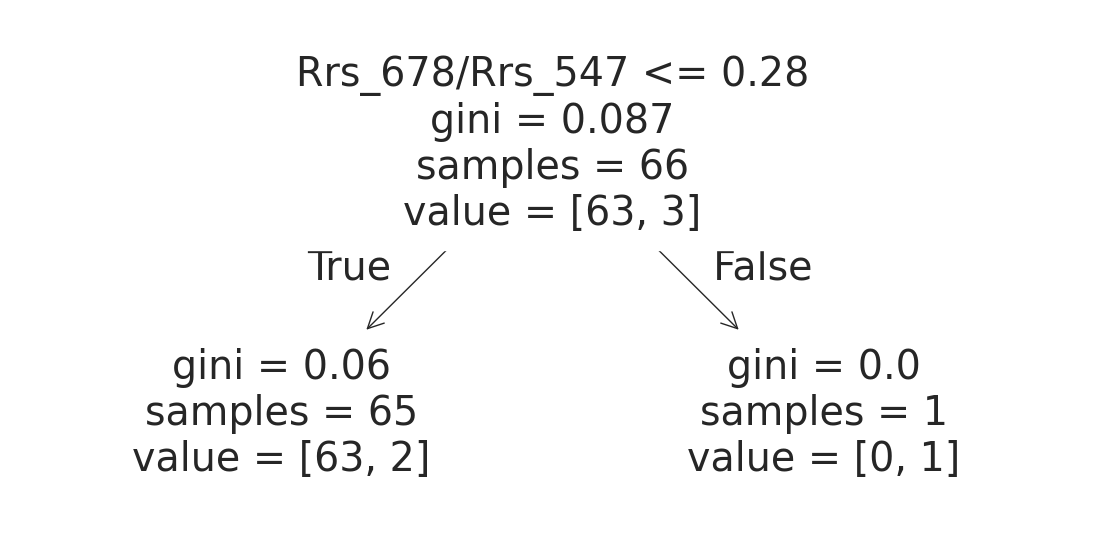

In [ ]:
def create_rrs_df_clf(df: pd.DataFrame, dict_os_bands: dict, sensor: str, mode: int = 0, extra_feat: int = 0) -> pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): _description_
        dict_os_bands (dict): _description_
        sensor (str): _description_
        mode (int, optional): 0 is 6 bands, 1 is all bands. Defaults to 0.
        extra_feat (int, optional): 0 is nothing, 1 is add combinations pf features. Defaults to 0.

    Returns:
        pd.DataFrame: df_rrs + column of type of water
    """
    
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    match sensor:
        case 'mod4':
            col = ['Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678'] \
                if mode else ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
        case 'mod1':
            col = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16'] \
                if mode else ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
                
    if extra_feat:
        for numerator, denominator in itertools.permutations(df_rrs.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs[ratio_name] = df_rrs[numerator] / df_rrs[denominator]
    
    return df_rrs.join(df['type_water'])


df_mod4['type_water'] = df_mod4['CHL'].apply(lambda x: 1 if x > THRESHOLD else 0)
df_mod1['type_water'] = df_mod1['CHL'].apply(lambda x: 1 if x > THRESHOLD else 0)

df_mod4_rrs10_classif_extra = create_rrs_df_clf(df_mod4, dict_stats_mod4, 'mod4', mode=1, extra_feat=1)
df_mod1_rrs10_classif_extra = create_rrs_df_clf(df_mod1, dict_stats_mod1, 'mod1', mode=1, extra_feat=1)


selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_selected_mod4_extra = selector.fit_transform(df_mod4_rrs10_classif_extra.iloc[:, :-1], df_mod4_rrs10_classif_extra['type_water'])

X_train_mod4_own_extra, X_test_mod4_own_extra, y_train_mod4_own_extra, y_test_mod4_own_extra = train_test_split(X_selected_mod4_extra, df_mod4_rrs10_classif_extra['type_water'],
                                                                        test_size=30, stratify=df_mod4_rrs10_classif_extra['type_water'], random_state=42)
tree_model_mod4_own = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_mod4_own_extra, y_train_mod4_own_extra)
selected_features_mod4_own = list(map(lambda x: df_mod4_rrs10_classif_extra.columns[x], selector.get_support(indices=True)))
selected_features_mod4_own

tree.plot_tree(tree_model_mod4_own, feature_names=selected_features_mod4_own);

print(f"Train Accuracy: {tree_model_mod4_own.score(X_train_mod4_own_extra, y_train_mod4_own_extra)} \
      Test Accuracy: {tree_model_mod4_own.score(X_test_mod4_own_extra, y_test_mod4_own_extra)}")

Train Accuracy: 0.9782608695652174    Test Accuracy: 0.9666666666666667


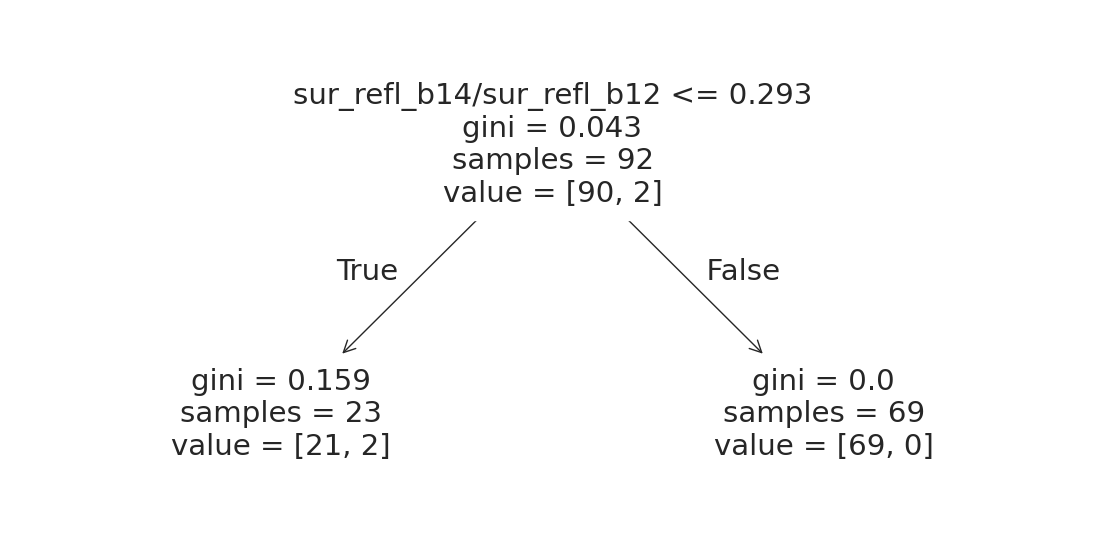

In [158]:
X_selected_mod1_extra = selector.fit_transform(df_mod1_rrs10_classif_extra.iloc[:, :-1], df_mod1_rrs10_classif_extra['type_water'])

X_train_mod1_own_extra, X_test_mod1_own_extra, y_train_mod1_own_extra, y_test_mod1_own_extra = train_test_split(X_selected_mod1_extra, df_mod1_rrs10_classif_extra['type_water'],
                                                                        test_size=30, stratify=df_mod1_rrs10_classif_extra['type_water'], random_state=42)
tree_model_mod1_own = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_mod1_own_extra, y_train_mod1_own_extra)
selected_features_mod1_own = list(map(lambda x: df_mod1_rrs10_classif_extra.columns[x], selector.get_support(indices=True)))
selected_features_mod1_own


tree.plot_tree(tree_model_mod1_own, feature_names=selected_features_mod1_own);



print(f"Train Accuracy: {tree_model_mod1_own.score(X_train_mod1_own_extra, y_train_mod1_own_extra)}\
    Test Accuracy: {tree_model_mod1_own.score(X_test_mod1_own_extra, y_test_mod1_own_extra)}")

# Final test

In [24]:
def create_rrs_df_rgr(df, dict_os_bands, sensor: str, emp_algo_data=None, mode=0):
    dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
    df_rrs = None
    match sensor:
        case 'mod4':
            col = ['Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678'] \
                if mode else ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
        case 'mod1':
            col = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16'] \
                if mode else ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13']
            df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
                .loc[:, col]
                
    indecies_set = set()            
    for column in df_rrs.columns:
        result = hampel(df_rrs[column])
        
        # Преобразование индексов выбросов в метки строк из in_situ
        outlier_indices = list(map(lambda t: df_rrs.index[t], result.outlier_indices))
        
        indecies_set.update(outlier_indices)
    
    df_rrs_cleaned = copy.deepcopy(df_rrs).drop(list(indecies_set))
    if emp_algo_data:
        for numerator, denominator in itertools.permutations(df_rrs_cleaned.columns, 2):
            ratio_name = f"{numerator}/{denominator}"
            df_rrs_cleaned[ratio_name] = df_rrs_cleaned[numerator] / df_rrs[denominator]
        for k, v in emp_algo_data.items():
            _t = pd.Series(v[-1])
            _t.name = k
            df_rrs_cleaned = df_rrs_cleaned.join(_t)
    
    return df_rrs_cleaned.join(df.loc[:, 'CHL'])


In [18]:
_df_all = pd.concat([_df_irk, _df_sev])
THRESHOLD = _df_all['CHL'].quantile(0.95)

df_all = copy.deepcopy(_df_all)

with open("supplement/data_mod4_all.pickle", "rb") as file:
    dict_stats_mod4 = clean_negative_rrs(pickle.load(file), "mod4")
    
with open("supplement/data_mod1_all.pickle", "rb") as file:
    dict_stats_mod1 = clean_negative_rrs(pickle.load(file), "mod1")
    
df_all_low = df_all[df_all['CHL'] <= THRESHOLD]
df_all_high = df_all[df_all['CHL'] > THRESHOLD]


dict_stats_mod4_low = {k: v for k, v in dict_stats_mod4.items() if k in df_all_low.index}
dict_stats_mod4_high = {k: v for k, v in dict_stats_mod4.items() if k in df_all_high.index}

dict_stats_mod1_low = {k: v for k, v in dict_stats_mod1.items() if k in df_all_low.index}
dict_stats_mod1_high = {k: v for k, v in dict_stats_mod1.items() if k in df_all_high.index}

df_mod4_low = df_all_low.loc[pd.Index(dict_stats_mod4_low.keys())]
df_mod4_high = df_all_high.loc[pd.Index(dict_stats_mod4_high.keys())]

df_mod1_low = df_all_low.loc[pd.Index(dict_stats_mod1_low.keys())]
df_mod1_high = df_all_high.loc[pd.Index(dict_stats_mod1_high.keys())]

In [26]:
mod1_data = main(dict_stats_mod1, df_all, "mod1")
mod4_data = main(dict_stats_mod4, df_all, "mod4")

In [31]:
create_rrs_df_rgr(
    df_all_high, dict_stats_mod4_high, 'mod4', emp_algo_data={'oc3_modis4': mod4_data['oc3_modis_4km'],
                   'oc4_modis4': mod4_data['oc4_modis_4km'], 'oc5_modis4': mod4_data['oc5_modis_4km'],
                   'oc6_modis4': mod4_data['oc6_modis_4km'],})

,Rrs_412,Rrs_443,Rrs_488,Rrs_531,Rrs_555,Rrs_667,Rrs_412/Rrs_443,Rrs_412/Rrs_488,Rrs_412/Rrs_531,Rrs_412/Rrs_555,...,Rrs_667/Rrs_412,Rrs_667/Rrs_443,Rrs_667/Rrs_488,Rrs_667/Rrs_531,Rrs_667/Rrs_555,oc3_modis4,oc4_modis4,oc5_modis4,oc6_modis4,CHL
50,0.000938,0.001328,0.001658,0.001736,0.001478,0.000146,0.706325,0.565742,0.540323,0.634642,...,0.155651,0.109940,0.088058,0.084102,0.098783,1.361961,1.413232,1.353871,1.194615,3.120000
154,0.004294,0.003524,0.003430,0.002450,0.001702,0.000142,1.218502,1.251895,1.752653,2.522913,...,0.033070,0.040295,0.041400,0.057960,0.083432,0.372517,0.313118,0.301196,0.314128,6.560000
170,0.002336,0.001386,0.001920,0.002506,0.002056,0.000674,1.685425,1.216667,0.932163,1.136187,...,0.288528,0.486292,0.351042,0.268955,0.327821,2.201449,1.372042,1.186834,1.749789,3.130000
287,0.000364,0.000672,0.001998,0.003048,0.002368,0.000388,0.541667,0.182183,0.119423,0.153717,...,1.065934,0.577382,0.194195,0.127297,0.163852,2.915618,2.894009,0.993164,1.105305,3.440000
289,0.001234,0.001282,0.001812,0.002734,0.002696,0.000418,0.962559,0.681016,0.451354,0.457715,...,0.338736,0.326054,0.230685,0.152890,0.155045,5.633165,5.545068,2.511037,1.978898,3.329076


In [21]:
dict_stats_mod4_high.keys()

dict_keys([50, 154, 170, 287, 289])

In [22]:
df_all_high.loc[[50, 154, 170, 287, 289], :]

,Name,LATITUDE,LONGITUDE,Depth,Wind,Press,Tsurf,Clouds_all/low,Clouds_type,Secky,CHL,FLAG_NEW,datetime
50,ц.ст. Ухан-Тонкий,52.891883,107.527283,1553,2.6,948.2,2.980,9/2,NaN,8,3.120000,NaN,2019-06-02T23:34:00
154,ц.ст. Кадильный-Мишиха,51.774183,105.364767,1425,5.4,945.8,2.632,1,Cr,9,6.560000,1.0,2020-06-04T08:56:00
170,ц.ст. Ухан-Тонкий,52.895017,107.533683,1555,3.8,959.8,9.304,NaN,NaN,NaN,3.130000,1.0,2021-09-22T10:53:00
287,NaN,55.046250,109.434100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.440000,NaN,2018-07-28T05:23:00
289,NaN,55.320350,109.483017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.329076,NaN,2018-07-29T04:50:00


# The commented code

In [ ]:
# плохая идея (выборка 40-50) станет

# def outliers(df_init: pd.DataFrame, threshold=6, window_size=3, n_sigma=3.0, **kwargs):
#     """_summary_

#     Args:
#         df_init (pd.DataFrame): _description_
#         threshold (int, optional): _description_. Defaults to 6.
#         window_size (int, optional): _description_. Defaults to 3.
#         n_sigma (float, optional): _description_. Defaults to 3.0.

#     Returns:
#         list: [df_pred, stat, indecies_dict]
#     """
    
#     df_pred = copy.deepcopy(df_init)
#     # df_clean = copy.deepcopy(df_init)
#     stat = dict()
#     indecies_set = set()
#     for algo_name, algo_dict in kwargs.items():
#         in_situ = pd.Series(algo_dict[-2])
#         predicted = pd.Series(algo_dict[-1])
#         residual = copy.deepcopy(np.abs(in_situ - predicted))
        
#         indecies_true = np.array([])
#         if len((inds_array := np.where(residual > threshold)[0])): 
#             indecies_true = list((map(lambda t: in_situ.index[t], inds_array)))
#             residual = np.delete(residual, inds_array)
            
#         result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
#         indecies = list(np.hstack((list(map(lambda t: in_situ.index[t], result.outlier_indices)), indecies_true)).astype(int))
#         indecies_set |= set(indecies)
#     #
#     for algo_name, algo_dict in kwargs.items():
#         in_situ = pd.Series(algo_dict[-2])
#         predicted = pd.Series(algo_dict[-1])
#         residual = copy.deepcopy(np.abs(in_situ - predicted))
#         for i in indecies_set: 
#             if i in in_situ: in_situ.pop(i), predicted.pop(i)
    
#         indecies_series = pd.Series({k: True if k in indecies_set else np.nan for k in indecies_set})
#         indecies_series.name = f'flag_hampel_{algo_name}'
#         predicted_in_table = pd.Series(algo_dict[-1])
#         predicted_in_table.name = algo_name
#         df_pred = pd.concat([df_pred, predicted_in_table, indecies_series], axis=1)
            
#         in_situ_values = copy.deepcopy(in_situ).to_list()
#         calc_chl = predicted.to_list()
#         if len(calc_chl) > 3:
#             stat[algo_name] = [*statistics(in_situ_values, calc_chl), len(calc_chl), in_situ, algo_dict]
#             slope = draw_graphic(in_situ_values, calc_chl, algo_name)
#             stat[algo_name].insert(6, slope)
#         else:
#             display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
#     for i in df_pred.index:
#         if df_pred.loc[i, 'datetime':].isna().sum() == len(kwargs) * 2:
#             df_pred.drop(labels=[i], inplace=True)
#     return df_pred, stat, indecies_set

In [ ]:
# def outliers(df_init: pd.DataFrame, threshold=10, window_size=3, n_sigma=3.0, **kwargs):
#     """_summary_

#     Args:
#         df_init (pd.DataFrame): _description_
#         threshold (int, optional): _description_. Defaults to 10.
#         window_size (int, optional): _description_. Defaults to 3.
#         n_sigma (float, optional): _description_. Defaults to 3.0.

#     Returns:
#         list: [df_pred, stat, indecies_dict]
#     """
    
#     df_pred = copy.deepcopy(df_init)
#     # df_clean = copy.deepcopy(df_init)
#     stat = dict()
#     indecies_dict = dict()
#     for algo_name, algo_dict in kwargs.items():
#         in_situ = pd.Series(algo_dict[-2])
#         predicted = pd.Series(algo_dict[-1])
#         residual = copy.deepcopy(np.abs(in_situ - predicted))
        
#         indecies_true = np.array([])
#         if len((inds_array := np.where(residual > threshold)[0])): 
#             indecies_true = list((map(lambda t: in_situ.index[t], inds_array)))
#             residual = np.delete(residual, inds_array)
            
#         result = hampel(residual, window_size=window_size, n_sigma=n_sigma)
#         indecies = list(np.hstack((list(map(lambda t: in_situ.index[t], result.outlier_indices)), indecies_true)).astype(int))
#         indecies_dict[algo_name] = indecies
        
#         for i in indecies: 
#             if i in in_situ: in_situ.pop(i), predicted.pop(i)
        
#         indecies_series = pd.Series({k: True if k in indecies else np.nan for k in indecies})
#         indecies_series.name = f'flag_hampel_{algo_name}'
#         predicted_in_table = pd.Series(algo_dict[-1])
#         predicted_in_table.name = algo_name
#         df_pred = pd.concat([df_pred, predicted_in_table, indecies_series], axis=1)
            
#         in_situ_values = copy.deepcopy(in_situ).to_list()
#         calc_chl = predicted.to_list()
#         if len(calc_chl) > 3:
#             stat[algo_name] = [*statistics(in_situ_values, calc_chl), len(calc_chl), in_situ, algo_dict]
#             slope = draw_graphic(in_situ_values, calc_chl, algo_name)
#             stat[algo_name].insert(6, slope)
#         else:
#             display(f"Incorrect estimated values (count = {len(calc_chl)}): {algo_name}")
#     for i in df_pred.index:
#         if df_pred.loc[i, 'datetime':].isna().sum() == len(kwargs) * 2:
#             df_pred.drop(labels=[i], inplace=True)
#     return df_pred, stat, indecies_dict

In [ ]:
# log_lin_model_1km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod1.items() if k not in clear_all_data[2]['log_lin_model_modis_1km']},
#                                                   {k: v for k, v in mod1_data['log_lin_model_modis_1km'][-2].items() if k not in clear_all_data[2]['log_lin_model_modis_1km']},
#                                                   "log_lin_model_modis_1km",
#                                                   lambda v: (np.log10(v[1]['sur_refl_b10'] / v[1]['sur_refl_b11']), np.log10(v[1]['sur_refl_b09'] / v[1]['sur_refl_b11'])), aflc,
#                                                   mode=1)
# log_lin_model_4km_nle = non_linear_estimation({k: v for k, v in dict_stats_mod4.items() if k not in clear_all_data[2]['log_lin_model_modis_4km']},
#                                                   {k: v for k, v in mod4_data['log_lin_model_modis_4km'][-2].items() if k not in clear_all_data[2]['log_lin_model_modis_4km']},
#                                                   "log_lin_model_modis_4km",
#                                                   lambda v: (np.log10(v[1]['Rrs_488'] / v[1]['Rrs_531']), np.log10(v[1]['Rrs_443'] / v[1]['Rrs_531'])), aflc,
#                                                   mode=1)

In [ ]:
# def custom_rmse_slope(in_situ, pred):
#     return np.sqrt(mean_squared_error(in_situ, pred)) + 2 * abs((theilslopes(pred, in_situ).slope - 1))

# def do_cross_validation_custom(clf, X, y):
#     scoring = {"custom_rmse_slope": make_scorer(custom_rmse_slope, greater_is_better=False)}
#     cv = cross_validate(clf, X, y, scoring=scoring, cv=5, return_estimator=True)
#     msg_dict = dict()
#     for m in scoring:
#         msg_dict[m] = [None, None]
#         msg_dict[m][0] = ' + '.join(f'{s:.2f}' for s in cv[f"test_{m}"])
#         msg_dict[m][1] = cv[f"test_{m}"].mean()
#         print(f"Cross-validated {m}: ({msg_dict[m][0]}) / 5 = {msg_dict[m][1]:.2f}")
#     print()
    
#     for fold_idx, estimator in enumerate(cv['estimator']):
#         best_params = estimator.best_params_
#         print(f"Hyperparams (fold number = {fold_idx + 1}): {best_params}")
#     res = [abs(msg_dict[_][1]) for _ in msg_dict]
#     return res

In [ ]:
# def report(lst: list, keys: tuple, df: pd.DataFrame, outliers: tuple, name_algo: str):
#     if list(df.columns)[-1] != "CHL":
#         columns = list(df.columns)
#         columns[-1], columns[-2] = columns[-2], columns[-1]
#         df = df[columns]
#     list_in_situ, list_calc = [], []
#     display_df = pd.DataFrame()
#     for i, ai in enumerate(keys):
#         if ai in outliers:
#             row = df.loc[df['ID'] == keys[i]].copy()
#             row[f"{name_algo}"] = lst[1][ai]
#             display_df = pd.concat([display_df, row], ignore_index=True)
#             continue
#         elif ai in lst[0]:
#             list_in_situ.append(lst[0][ai])
#             list_calc.append(lst[1][ai])
#     res = [*statistics(list_in_situ, list_calc), f'{len(list_in_situ)}/{len(lst[0])}']
#     _s = draw_graphic(list_in_situ, list_calc, name_algo)
#     res.insert(6, _s)
#     display(display_df.set_index('ID'))
#     return res

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.hist(df_all['CHL'], bins=35, color='skyblue', edgecolor='black')
# plt.axvline(x=df_all['CHL'].median(), color='red', linestyle='--', label="Медиана")
# plt.title("Гистограмма концентраций хлорофилла-a")
# plt.xlabel("Концентрация хлорофилла-a (мкг/л)")
# plt.ylabel("Частота")
# plt.legend();

# ---

# import seaborn as sns


# plt.figure(figsize=(10, 6))
# sns.kdeplot(df_all['CHL'], fill=True, color='green', label="Оценка плотности")
# plt.axvline(x=df_all['CHL'].median(), color='red', linestyle='--', label="Медиана")
# plt.title("Оценка плотности распределения концентраций хлорофилла-a")
# plt.xlabel("Концентрация хлорофилла-a (мкг/л)")
# plt.ylabel("Плотность")
# plt.legend();

#---

# df1 = pd.read_csv("data_chl/irkutsk_wind.csv")
# df2 = pd.read_csv('data_chl/sevastopol.csv')

# wind_values = np.array(df1['WIND'].tolist())
# wind_values =np.strings.replace(wind_values, ',', '.')
# for i, ai in enumerate(wind_values):
#     if '(' in ai:
#         wind_values[i] = ai[ai.find('(') + 1:ai.find(')')]
# wind_values = np.array(wind_values, dtype='float')
# df1["WIND"] = wind_values

# df_irk_wind = convert_datetime_irkutsk(df1)
# df_irk_wind = convert_degreendmin_to_degree(df_irk_wind, 'LONGITUDE')
# df_irk_wind = convert_degreendmin_to_degree(df_irk_wind, 'LATITUDE')

# df_irk_wind = df_irk_wind[df_irk_wind["WIND"] < 5]
# df_irk_wind["WIND"].describe()

# df_irk = convert_datetime_irkutsk(df1)
# df_irk = convert_degreendmin_to_degree(df_irk, 'LONGITUDE')
# df_irk = convert_degreendmin_to_degree(df_irk, 'LATITUDE')
# df_irk

# for i, k in enumerate(df2.datetime):
#     dt_datetime = datetime.strptime(k, '%Y-%m-%d %H:%M:%S')
#     df2.loc[i, 'datetime'] = dt_datetime.strftime('%Y-%m-%dT%H:%M:%S')
# df2.drop(columns=['depth', 'station', 'deptpd.DataFrame.from_dict({"SVR_MOD4": do_cross_validation(GridSearchCV(make_pipeline(StandardScaler(), svr), param_grid, cv=5, scoring='neg_root_mean_squared_error'), df_mod4_rrs_own.loc[:, :'Rrs_667'], target_mod4)}, orient='index', columns=columns)h', 'id_old', 'geometry'], inplace=True)
# df_sev = df2.copy()
# df_sev.rename(columns={'datetime': 'date_time', 'Latitude': 'LATITUDE', 'Longitude': 'LONGITUDE', 'TChl-a': 'CHL'}, inplace=True)
# #

In [65]:
# def convert_stat_dict_to_list_stat_and_values(init_dict: dict, sensor: str, sat: str):
#     """
#     Args:
#         init_dict: {"name_algo1": [r2, bias, mae, n/k, [in situ], [calculated]], "name_algo2": ...}
#     Return:
#         [{statustics (7 keys)}, {"name_algo" : [[in situ], [calculated]]}]
#     """
    
#     statistics_dict = {}
#     data_dict = {}
#     if sensor == "oli":
#         statistics_dict["oc3_oli"] = init_dict["oc3_oli"][:-2]
#         data_dict["oc3_oli"] = [init_dict["oc3_oli"][-2], init_dict["oc3_oli"][-1]]
#     else:
#         statistics_dict[f"oc3_modis_{sat}"] = init_dict[f"oc3_modis_{sat}"][:-2]
#         data_dict[f"oc3_modis_{sat}"] = [init_dict[f"oc3_modis_{sat}"][-2], init_dict[f"oc3_modis_{sat}"][-1]]
        
#         statistics_dict[f"oc4_modis_{sat}"] = init_dict[f"oc4_modis_{sat}"][:-2]
#         data_dict[f"oc4_modis_{sat}"] = [init_dict[f"oc4_modis_{sat}"][-2], init_dict[f"oc4_modis_{sat}"][-1]]
        
#         statistics_dict[f"oc5_modis_{sat}"] = init_dict[f"oc5_modis_{sat}"][:-2]
#         data_dict[f"oc5_modis_{sat}"] = [init_dict[f"oc5_modis_{sat}"][-2], init_dict[f"oc5_modis_{sat}"][-1]]
        
#         statistics_dict[f"oc6_modis_{sat}"] = init_dict[f"oc6_modis_{sat}"][:-2]
#         data_dict[f"oc6_modis_{sat}"] = [init_dict[f"oc6_modis_{sat}"][-2], init_dict[f"oc6_modis_{sat}"][-1]]
#     return [statistics_dict, data_dict]

In [ ]:
"""
# dict_stats_mod4_irk = copy.deepcopy(_dict_stats_mod4_irk)
# for i in (0, 1, 4,  37, 54):
#     del dict_stats_mod4_irk[list(_dict_stats_mod4_irk.keys())[i]]

# dict_stats_mod4_sev = copy.deepcopy(_dict_stats_mod4_sev)
# for i in (3, 7, 13, 14, 15, 16, 19, 20, 23, 26):
#     del dict_stats_mod4_sev[list(_dict_stats_mod4_sev.keys())[i]]

# dict_stats_oli_irk = copy.deepcopy(_dict_stats_oli_irk)
# del dict_stats_oli_irk[list(_dict_stats_oli_irk.keys())[9]]
# del dict_stats_oli_irk[list(_dict_stats_oli_irk.keys())[10]]
# del dict_stats_oli_irk[list(_dict_stats_oli_irk.keys())[11]] 

# dict_stats_mod1_irk = copy.deepcopy(_dict_stats_mod1_irk)
# for i in (0, 1, 5, 6, 7, 11, 12, 22, 24, 27, 29, 30, 31, 32, 34, 36, 37, 38, 45, 46, 47, 49):
#     del dict_stats_mod1_irk[list(_dict_stats_mod1_irk.keys())[i]]

# dict_stats_mod1_sev = copy.deepcopy(_dict_stats_mod1_sev)
# for i in (1, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 26, 29, 30):
#     del dict_stats_mod1_sev[list(_dict_stats_mod1_sev.keys())[i]]

# common_keys_irk = set(dict_stats_mod4_irk.keys()) & set(dict_stats_mod1_irk.keys())

# dict_stats_mod4_common_irk = copy.deepcopy(dict_stats_mod4_irk)
# print(len(dict_stats_mod4_irk))
# for i in dict_stats_mod4_irk:
#     if i not in common_keys_irk:
#         del dict_stats_mod4_common_irk[i]
# print(len(dict_stats_mod4_common_irk))

# dict_stats_mod1_common_irk = copy.deepcopy(dict_stats_mod1_irk)
# print(len(dict_stats_mod1_irk))
# for i in dict_stats_mod1_irk:
#     if i not in common_keys_irk:
#         del dict_stats_mod1_common_irk[i]
# print(len(dict_stats_mod1_common_irk))

#len(set(dict_stats_mod4_sev.keys()) & set(dict_stats_mod1_sev.keys()))

#len(set(dict_stats_mod4_irk.keys()) & set(dict_stats_mod1_irk.keys()) & set(dict_stats_oli_irk.keys()))

def pars_input_str(inp_str): 
    _name, _coord = [], []
    indices = [2 + 3*k for k in range(50)]
    for i, ai in enumerate(inp_str):
        if i % 3 == 0:
            _name.append(ai.split()[1])
        elif i in indices:
            _coord.append([float(ai.split('\t')[3]), float(ai.split('\t')[4])])
    return len(_name), _name, _coord


# pars_input_str(__str.split('\n'))
"""

In [ ]:
# outliers_data = clear_all_data[0]
# outliers_data.columns
# outliers_data[outliers_data[[
#     'oc3_modis_4km', 'oc4_modis_4km', 'oc5_modis_4km', 'oc6_modis_4km', 'oc3_modis_1km', 'oc4_modis_1km', 'oc5_modis_1km', 'oc6_modis_1km', 'oc3_oli'
#     ]].sub(outliers_data['CHL'], axis=0) > 0.1]\
#     .loc[:80, 
#          ['oc3_modis_4km', 'oc4_modis_4km', 'oc5_modis_4km', 'oc6_modis_4km', 'oc3_modis_1km', 'oc4_modis_1km', 'oc5_modis_1km', 'oc6_modis_1km', 'oc3_oli']
#          ]
    
#     # df[columns_to_subtract] = df[columns_to_subtract].sub(df['D'], axis=0)


In [ ]:
# def caledonia(model, n_resamples: int, df_rrs: pd.DataFrame, confidence_level: float) -> list:
#     """_summary_
    
#     Args:
#         model: not trained
#         df_rrs (pd.DataFrame): columns[-2] == CHL
#         confidence_level (float): _description_

#     Returns:
#         pd.DataFrame: RMSE + Sen's slope (mean, confidence interaval, Kruskal test) for each models
#     """
    
#     alpha = 1 - confidence_level
#     df_result = pd.DataFrame() 
#     all_features = list(
#         itertools.chain.from_iterable(itertools.combinations(df_rrs.columns[:-2], r) for r in range(1, 7))
#         )
#     np.random.seed(42)
#     bootstrap_samples_keys = np.random.choice(df_rrs.index, (n_resamples, df_rrs.shape[0]), replace=True)
#     rmse_dict, rmse_full_dict, sens_slope_dict, sens_slope_full_dict= dict(), dict(), dict(), dict()
#     rmse_ci, sslope_ci = dict(), dict()
#     keys = dict()
#     for combo_idx, combo in enumerate(all_features):
#         rmse_bs_current, sens_slope_bs_current = np.zeros(n_resamples, dtype=np.float64), np.zeros(n_resamples, dtype=np.float64)
        
#         rmse_bootstrap = []
#         sens_slope_bootstrap = []
#         se_rmse_bootstrap = []
#         se_sens_bootstrap = []
        
#         df_full = df_rrs.loc[:, combo].join(df_rrs['CHL'])
#         X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
#             df_full.iloc[:, :-1], df_full['CHL'],
#             test_size=30, random_state=42
#         )
#         pipe_full = make_pipeline(StandardScaler(), model())
#         pipe_full.fit(X_train_full, y_train_full)
#         y_pred_full = pipe_full.predict(X_test_full)

#         # RMSE и Sen's slope по исходной выборке
#         rmse_full = np.sqrt(mean_squared_error(y_test_full, y_pred_full))
#         sens_full = theilslopes(y_pred_full, y_test_full).slope

#         # Стандартная ошибка RMSE и Sen's slope по исходной выборке
#         # se_rmse_full = np.sqrt(rmse_full / X_test_full.shape[0])  # Приближение
#         # se_sens_full = 1.0  # Можно заменить на реальную оценку
        
#         # se_rmse_full = np.std(rmse_bootstrap)
#         # se_sens_full = np.std(sens_slope_bootstrap)
        
#         for i, indecies_current in enumerate(bootstrap_samples_keys):
#             df_current = df_rrs.loc[indecies_current, combo].join(df_rrs['CHL'])
#             X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(df_current.iloc[:, :-1], df_current['CHL'],
#                                                                         test_size=30, random_state=42)
#             pipe = make_pipeline(StandardScaler(), model())
#             pipe.fit(X_train_current, y_train_current)
#             y_pred_current = pipe.predict(X_test_current)
#             rmse_bs_current[i], sens_slope_bs_current[i] = np.sqrt(mean_squared_error(y_pred_current, y_test_current)), theilslopes(y_pred_current, y_test_current).slope

#             # Стандартная ошибка RMSE и Sen's slope по бутстрап-выборке
#             # se_rmse_i = np.sqrt(rmse_bs_current[i] / X_test_current.shape[0])  # Приближение
#             # se_sens_i = 1.0  # Можно заменить на реальную оценку

#             se_rmse_i = np.std([np.sqrt(mean_squared_error(y_pred_current[np.random.choice(len(y_pred_current), len(y_pred_current), replace=True)], 
#                                         y_test_current[np.random.choice(len(y_test_current), len(y_test_current), replace=True)])) 
#                         for _ in range(100)])
#             sens_estimates = [theilslopes(
#                 y_pred_current[np.random.choice(len(y_pred_current), len(y_pred_current), replace=True)],
#                 y_test_current[np.random.choice(len(y_test_current), len(y_test_current), replace=True)]
#             ).slope for _ in range(100)]  # 100 повторений для оценки SE
#             se_sens_i = np.std(sens_estimates)
            
#             # Сохранение статистик
#             rmse_bootstrap.append(rmse_bs_current[i])
#             sens_slope_bootstrap.append(sens_slope_bs_current[i])
#             se_rmse_bootstrap.append(se_rmse_i)
#             se_sens_bootstrap.append(se_sens_i)
        
#         se_rmse_full = np.std([np.sqrt(mean_squared_error(
#             y_pred_full[np.random.choice(len(y_pred_full), len(y_pred_full), replace=True)],
#             y_test_full[np.random.choice(len(y_test_full), len(y_test_full), replace=True)]
#         )) for _ in range(100)])
        
#         se_sens_full = np.std([theilslopes(
#             y_pred_full[np.random.choice(len(y_pred_full), len(y_pred_full), replace=True)],
#             y_test_full[np.random.choice(len(y_test_full), len(y_test_full), replace=True)]
#         ).slope for _ in range(100)])
               
#         t_rmse = [(rmse_i - rmse_full) / se_rmse_i for rmse_i, se_rmse_i in zip(rmse_bootstrap, se_rmse_bootstrap)]
#         t_sens = [(sens_i - sens_full) / se_sens_i for sens_i, se_sens_i in zip(sens_slope_bootstrap, se_sens_bootstrap)]

#         # Нахождение квантилей
#         t_rmse = np.sort(t_rmse)
#         t_sens = np.sort(t_sens)
#         q_lower = int(np.floor(alpha / 2 * n_resamples))
#         q_upper = int(np.ceil((1 - alpha / 2) * n_resamples))

#         # Построение доверительного интервала
#         ci_rmse_lower = rmse_full - t_rmse[q_upper] * se_rmse_full
#         ci_rmse_upper = rmse_full - t_rmse[q_lower] * se_rmse_full
#         ci_sens_lower = sens_full - t_sens[q_upper] * se_sens_full
#         ci_sens_upper = sens_full - t_sens[q_lower] * se_sens_full
        
#         rmse_full_dict[combo_idx] = rmse_full
#         rmse_ci[combo_idx] = ci_rmse_upper - ci_rmse_lower
#         sens_slope_full_dict[combo_idx] = sens_full
#         sslope_ci[combo_idx] = ci_sens_upper - ci_sens_lower
#         keys[combo_idx] = combo
#         rmse_dict[combo_idx], sens_slope_dict[combo_idx] = rmse_bs_current.mean(), sens_slope_bs_current.mean()
        
    
#     df_result['RMSE initial'] = rmse_full_dict
#     df_result['RMSE mean'] = rmse_dict
#     df_result['RMSE CI Length'] = rmse_ci
    
#     df_result['Sen\'s slope initial'] = sens_slope_full_dict
#     df_result['Sen\'s slope mean'] = sens_slope_dict
#     df_result['Sen\'s slope CI Length'] = sslope_ci
#     return df_result, keys
    

In [ ]:
# oc3_4km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod4_high.items() if k not in clear_all_data_high[2]['oc3_modis_4km']},
#                                         {k: v for k, v in mod4_data_high['oc3_modis_4km'][-2].items() if k not in clear_all_data_high[2]['oc3_modis_4km']},
#                                         "oc3_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis)
# oc3_1km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod1_high.items() if k not in clear_all_data_high[2]['oc3_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_high['oc3_modis_1km'][-2].items() if k not in clear_all_data_high[2]['oc3_modis_1km']},
#                                         "oc3_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)

In [ ]:

# # oc3_4km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod4_low.items() if k not in clear_all_data_low[2]['oc3_modis_4km']},
# #                                         {k: v for k, v in mod4_data_low['oc3_modis_4km'][-2].items() if k not in clear_all_data_low[2]['oc3_modis_4km']},
# #                                         "oc3_modis_4km",
# #                                         lambda v: np.log10(max(v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis,
# #                                         bounds=[[0.25, -2.65, 1.27, 1.07, -1.77], [0.27, -2.63, 1.29, 1.09, -1.75]])
# # np.linalg.cond(oc3_4km_nle_low[1]), oc3_4km_nle_low[0]

# oc3_4km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod4_low.items() if k not in clear_all_data_low[2]['oc3_modis_4km']},
#                                         {k: v for k, v in mod4_data_low['oc3_modis_4km'][-2].items() if k not in clear_all_data_low[2]['oc3_modis_4km']},
#                                         "oc3_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis)
# oc3_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['oc3_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_low['oc3_modis_1km'][-2].items() if k not in clear_all_data_low[2]['oc3_modis_1km']},
#                                         "oc3_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)


# # oc3_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['oc3_modis_1km']}, 
# #                                         {k: v for k, v in mod1_data_low['oc3_modis_1km'][-2].items() if k not in clear_all_data_low[2]['oc3_modis_1km']},
# #                                         "oc3_modis_1km",
# #                                         lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis,
# #                                         bounds=[[0.25, -2.65, 1.27, 1.07, -1.77], [0.27, -2.63, 1.29, 1.09, -1.75]])
# # np.linalg.cond(oc3_1km_nle_low[1]), oc3_1km_nle_low[0]


# oc4_4km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod4_low.items() if k not in clear_all_data_low[2]['oc4_modis_4km']},
#                                         {k: v for k, v in mod4_data_low['oc4_modis_4km'][-2].items() if k not in clear_all_data_low[2]['oc4_modis_4km']},
#                                         "oc4_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis)
# oc4_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['oc4_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_low['oc4_modis_1km'][-2].items() if k not in clear_all_data_low[2]['oc4_modis_1km']},
#                                         "oc4_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b08'], v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)

# oc4_4km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod4_high.items() if k not in clear_all_data_high[2]['oc4_modis_4km']},
#                                         {k: v for k, v in mod4_data_high['oc4_modis_4km'][-2].items() if k not in clear_all_data_high[2]['oc4_modis_4km']},
#                                         "oc4_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488']) / v[1]['Rrs_555']), oc_modis)
# oc4_1km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod1_high.items() if k not in clear_all_data_high[2]['oc4_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_high['oc4_modis_1km'][-2].items() if k not in clear_all_data_high[2]['oc4_modis_1km']},
#                                         "oc4_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b08'], v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / v[1]['sur_refl_b12']), oc_modis)


# oc5_4km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod4_high.items() if k not in clear_all_data_high[2]['oc5_modis_4km']},
#                                         {k: v for k, v in mod4_data_high['oc5_modis_4km'][-2].items() if k not in clear_all_data_high[2]['oc5_modis_4km']},
#                                         "oc5_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488'], v[1]['Rrs_531']) / v[1]['Rrs_555']), oc_modis)
# oc5_1km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod1_high.items() if k not in clear_all_data_high[2]['oc5_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_high['oc5_modis_1km'][-2].items() if k not in clear_all_data_high[2]['oc5_modis_1km']},
#                                         "oc5_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b08'], v[1]['sur_refl_b09'], v[1]['sur_refl_b10'], v[1]['sur_refl_b11']) / v[1]['sur_refl_b12']), oc_modis)

# oc6_4km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod4_low.items() if k not in clear_all_data_low[2]['oc6_modis_4km']},
#                                         {k: v for k, v in mod4_data_low['oc6_modis_4km'][-2].items() if k not in clear_all_data_low[2]['oc6_modis_4km']},
#                                         "oc6_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488'], v[1]['Rrs_531']) / ((v[1]['Rrs_555'] + v[1]['Rrs_555']) / 2)),
#                                         oc_modis)
# oc6_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['oc6_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_low['oc6_modis_1km'][-2].items() if k not in clear_all_data_low[2]['oc6_modis_1km']},
#                                         "oc6_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / ((v[1]['sur_refl_b12'] + v[1]['sur_refl_b13']) / 2)),
#                                         oc_modis)
# oc6_4km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod4_high.items() if k not in clear_all_data_high[2]['oc6_modis_4km']},
#                                         {k: v for k, v in mod4_data_high['oc6_modis_4km'][-2].items() if k not in clear_all_data_high[2]['oc6_modis_4km']},
#                                         "oc6_modis_4km",
#                                         lambda v: np.log10(max(v[1]['Rrs_412'], v[1]['Rrs_443'], v[1]['Rrs_488'], v[1]['Rrs_531']) / ((v[1]['Rrs_555'] + v[1]['Rrs_555']) / 2)),
#                                         oc_modis)
# oc6_1km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod1_high.items() if k not in clear_all_data_high[2]['oc6_modis_1km']}, 
#                                         {k: v for k, v in mod1_data_high['oc6_modis_1km'][-2].items() if k not in clear_all_data_high[2]['oc6_modis_1km']},
#                                         "oc6_modis_1km",
#                                         lambda v: np.log10(max(v[1]['sur_refl_b09'], v[1]['sur_refl_b10']) / ((v[1]['sur_refl_b12'] + v[1]['sur_refl_b13']) / 2)),
#                                         oc_modis)
# log_lin_model_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['log_lin_model_modis_1km']},
#                                                   {k: v for k, v in mod1_data_low['log_lin_model_modis_1km'][-2].items() if k not in clear_all_data_low[2]['log_lin_model_modis_1km']},
#                                                   "log_lin_model_modis_1km",
#                                                   lambda v: (np.log10(v[1]['sur_refl_b10'] / v[1]['sur_refl_b11']), np.log10(v[1]['sur_refl_b09'] / v[1]['sur_refl_b11'])), aflc,
#                                                   bounds=[[-2.6, 0.3, -0.2], [-2.4, 0.5, -0.06]], mode=1)
# np.linalg.cond(log_lin_model_1km_nle_low[1]), log_lin_model_1km_nle_low[0]

# log_lin_model_1km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod1_low.items() if k not in clear_all_data_low[2]['log_lin_model_modis_1km']},
#                                                   {k: v for k, v in mod1_data_low['log_lin_model_modis_1km'][-2].items() if k not in clear_all_data_low[2]['log_lin_model_modis_1km']},
#                                                   "log_lin_model_modis_1km",
#                                                   lambda v: (np.log10(v[1]['sur_refl_b10'] / v[1]['sur_refl_b11']), np.log10(v[1]['sur_refl_b09'] / v[1]['sur_refl_b11'])), aflc,
#                                                   mode=1)
# log_lin_model_4km_nle_low = non_linear_estimation({k: v for k, v in dict_stats_mod4_low.items() if k not in clear_all_data_low[2]['log_lin_model_modis_4km']},
#                                                   {k: v for k, v in mod4_data_low['log_lin_model_modis_4km'][-2].items() if k not in clear_all_data_low[2]['log_lin_model_modis_4km']},
#                                                   "log_lin_model_modis_4km",
#                                                   lambda v: (np.log10(v[1]['Rrs_488'] / v[1]['Rrs_531']), np.log10(v[1]['Rrs_443'] / v[1]['Rrs_531'])), aflc,
#                                                   mode=1)

# log_lin_model_1km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod1_high.items() if k not in clear_all_data_high[2]['log_lin_model_modis_1km']},
#                                                   {k: v for k, v in mod1_data_high['log_lin_model_modis_1km'][-2].items() if k not in clear_all_data_high[2]['log_lin_model_modis_1km']},
#                                                   "log_lin_model_modis_1km",
#                                                   lambda v: (np.log10(v[1]['sur_refl_b10'] / v[1]['sur_refl_b11']), np.log10(v[1]['sur_refl_b09'] / v[1]['sur_refl_b11'])), aflc,
#                                                   mode=1)
# log_lin_model_4km_nle_high = non_linear_estimation({k: v for k, v in dict_stats_mod4_high.items() if k not in clear_all_data_high[2]['log_lin_model_modis_4km']},
#                                                   {k: v for k, v in mod4_data_high['log_lin_model_modis_4km'][-2].items() if k not in clear_all_data_high[2]['log_lin_model_modis_4km']},
#                                                   "log_lin_model_modis_4km",
#                                                   lambda v: (np.log10(v[1]['Rrs_488'] / v[1]['Rrs_531']), np.log10(v[1]['Rrs_443'] / v[1]['Rrs_531'])), aflc,
#                                                   mode=1)

# print('\tHigh concentrated')
# pd.concat([oc3_4km_nle_high[2],
#            oc4_4km_nle_high[2],
#            oc5_4km_nle_high[2],
#            oc6_4km_nle_high[2],
#            log_lin_model_4km_nle_high[2],
           
#            oc3_1km_nle_high[2],
#            oc4_1km_nle_high[2],
#            oc5_1km_nle_high[2],
#            oc6_1km_nle_high[2],
#            log_lin_model_1km_nle_high[2]
#            ])
# df_all_low = copy.deepcopy(df_all[df_all['CHL'] <= THRESHOLD])
# df_all_high = copy.deepcopy(df_all[df_all['CHL'] > THRESHOLD])

# dict_stats_mod4_low = {k: v for k, v in dict_stats_mod4.items() if k in df_all_low.index} #and k not in clear_all_data[2]["oc3_modis_4km"]}
# dict_stats_mod4_high = {k: v for k, v in dict_stats_mod4.items() if k in df_all_high.index} # and k not in clear_all_data[2]["oc3_modis_4km"]}

# dict_stats_mod1_low = {k: v for k, v in dict_stats_mod1.items() if k in df_all_low.index} # and k not in clear_all_data[2]["oc3_modis_1km"]}
# dict_stats_mod1_high = {k: v for k, v in dict_stats_mod1.items() if k in df_all_high.index} # and k not in clear_all_data[2]["oc3_modis_1km"]}

# dict_stats_oli_low = {k: v for k, v in dict_stats_oli.items() if k in df_all_low.index} # and k not in clear_all_data[2]["oc3_oli"]}
# dict_stats_oli_high = {k: v for k, v in dict_stats_oli.items() if k in df_all_high.index} # and k not in clear_all_data[2]["oc3_oli"]}

---

Классификатор пнем. Использованы всевозможные доступные 9-10 признаков и их комбинации в виде отношения band_i / band_k. Значимость признаков определены по критерию Фишера, отобраны 10 самых знычимых

In [ ]:
# def check_normality_by_class(df: pd.DataFrame, target_col: str):
#     """
#     Проверяет нормальность признаков в каждом классе целевой переменной.
    
#     Args:
#         df (pd.DataFrame): DataFrame с признаками и целевой переменной.
#         target_col (str): Название целевой переменной (например, 'type_water').
    
#     Returns:
#         pd.DataFrame: Таблица с результатами теста Шапиро-Уилка.
#     """
#     results = []
#     features = df.columns.drop(target_col)
    
#     for feature in features:
#         for cls, group in df.groupby(target_col)[feature]:
#             if len(group) < 3:
#                 print(f"Слишком мало данных для класса {cls} и признака {feature}. Пропуск.")
#                 continue
                
#             stat, p = shapiro(group)
#             is_normal = p > 0.05
#             results.append({
#                 'feature': feature,
#                 'class': cls,
#                 'shapiro_stat': stat,
#                 'p_value': p,
#                 'is_normal': is_normal
#             })
    
#     return pd.DataFrame(results)


# def create_rrs_df_clf(df: pd.DataFrame, dict_os_bands: dict, sensor: str, mode: int = 0, extra_feat: int = 0) -> pd.DataFrame:
#     """_summary_

#     Args:
#         df (pd.DataFrame): _description_
#         dict_os_bands (dict): _description_
#         sensor (str): _description_
#         mode (int, optional): 0 is 6 bands, 1 is all bands. Defaults to 0.
#         extra_feat (int, optional): 0 is nothing, 1 is add combinations pf features. Defaults to 0.

#     Returns:
#         pd.DataFrame: df_rrs + column of type of water
#     """
    
#     dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
#     df_rrs = None
#     match sensor:
#         case 'mod4':
#             col = ['Rrs_412', 'Rrs_443', 'Rrs_469', 'Rrs_488', 'Rrs_531', 'Rrs_547', 'Rrs_555', 'Rrs_645', 'Rrs_667', 'Rrs_678'] \
#                 if mode else ['Rrs_412', 'Rrs_443', 'Rrs_488', 'Rrs_531', 'Rrs_555', 'Rrs_667']
#             df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
#                 .loc[:, col]
#         case 'mod1':
#             col = ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13', 'sur_refl_b14', 'sur_refl_b15', 'sur_refl_b16'] \
#                 if mode else ['sur_refl_b08', 'sur_refl_b09', 'sur_refl_b10', 'sur_refl_b11', 'sur_refl_b12', 'sur_refl_b13']
#             df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
#                 .loc[:, col]
                
#     if extra_feat:
#         for numerator, denominator in itertools.permutations(df_rrs.columns, 2):
#             ratio_name = f"{numerator}/{denominator}"
#             df_rrs[ratio_name] = df_rrs[numerator] / df_rrs[denominator]
    
#     return df_rrs.join(df['type_water'])


# df_mod4['type_water'] = df_mod4['CHL'].apply(lambda x: 1 if x > THRESHOLD else 0)
# df_mod1['type_water'] = df_mod1['CHL'].apply(lambda x: 1 if x > THRESHOLD else 0)

# df_mod4_rrs10_classif_extra = create_rrs_df_clf(df_mod4, dict_stats_mod4, 'mod4', mode=1, extra_feat=1)
# df_mod1_rrs10_classif_extra = create_rrs_df_clf(df_mod1, dict_stats_mod1, 'mod1', mode=1, extra_feat=1)

# # Проверка нормальности для df_mod4_rrs_own_classif
# print("Результаты для MOD4:")
# print(check_normality_by_class(df_mod4_rrs10_classif_extra, 'type_water'))


# # Проверка нормальности для df_mod1_rrs_own_classif
# print("\nРезультаты для MOD1:")
# print(check_normality_by_class(df_mod1_rrs10_classif_extra, 'type_water'))
# selector = SelectKBest(score_func=mutual_info_classif, k=10)
# X_selected_mod4_extra = selector.fit_transform(df_mod4_rrs10_classif_extra.iloc[:, :-1], df_mod4_rrs10_classif_extra['type_water'])

# X_train_mod4_own_extra, X_test_mod4_own_extra, y_train_mod4_own_extra, y_test_mod4_own_extra = train_test_split(X_selected_mod4_extra, df_mod4_rrs10_classif_extra['type_water'],
#                                                                         test_size=30, stratify=df_mod4_rrs10_classif_extra['type_water'], random_state=42)
# tree_model_mod4_own = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_mod4_own_extra, y_train_mod4_own_extra)
# selected_features_mod4_own = list(map(lambda x: df_mod4_rrs10_classif_extra.columns[x], selector.get_support(indices=True)))
# selected_features_mod4_own

# tree.plot_tree(tree_model_mod4_own, feature_names=selected_features_mod4_own);

# print(f"Train Accuracy: {tree_model_mod4_own.score(X_train_mod4_own_extra, y_train_mod4_own_extra)} \
#       Test Accuracy: {tree_model_mod4_own.score(X_test_mod4_own_extra, y_test_mod4_own_extra)}")


# X_selected_mod1_extra = selector.fit_transform(df_mod1_rrs10_classif_extra.iloc[:, :-1], df_mod1_rrs10_classif_extra['type_water'])

# X_train_mod1_own_extra, X_test_mod1_own_extra, y_train_mod1_own_extra, y_test_mod1_own_extra = train_test_split(X_selected_mod1_extra, df_mod1_rrs10_classif_extra['type_water'],
#                                                                         test_size=30, stratify=df_mod1_rrs10_classif_extra['type_water'], random_state=42)
# tree_model_mod1_own = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_mod1_own_extra, y_train_mod1_own_extra)
# selected_features_mod1_own = list(map(lambda x: df_mod1_rrs10_classif_extra.columns[x], selector.get_support(indices=True)))
# selected_features_mod1_own


# tree.plot_tree(tree_model_mod1_own, feature_names=selected_features_mod1_own);



# print(f"Train Accuracy: {tree_model_mod1_own.score(X_train_mod1_own_extra, y_train_mod1_own_extra)}\
#     Test Accuracy: {tree_model_mod1_own.score(X_test_mod1_own_extra, y_test_mod1_own_extra)}")

---

In [ ]:
# def create_rrs_df_article(df, dict_os_bands, sensor: str):
#     dict_os_bands = {k: v[1] for k, v in dict_os_bands.items()}
#     df_rrs = None
#     match sensor:
#         case 'mod4':
#             df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
#                 .loc[:, ['Rrs_488', 'Rrs_555']]
#             df_rrs['Rrs_488 / Rrs_555'] = df_rrs['Rrs_488'] / df_rrs['Rrs_555']
#             df_rrs.drop(columns=['Rrs_488', 'Rrs_555'], inplace=True)
#         case 'mod1':
#             df_rrs = pd.DataFrame.from_dict(dict_os_bands, orient='index')\
#                 .loc[:, ['sur_refl_b10', 'sur_refl_b12']]
#             df_rrs['sur_refl_b10 / sur_refl_b12'] = df_rrs['sur_refl_b10'] / df_rrs['sur_refl_b12']
#             df_rrs.drop(columns=['sur_refl_b10', 'sur_refl_b12'], inplace=True)
#     return df_rrs.join(df['type_water'])


# df_mod4_rrs_art = create_rrs_df_article(df_mod4, dict_stats_mod4, 'mod4')
# df_mod1_rrs_art = create_rrs_df_article(df_mod1, dict_stats_mod1, 'mod1')

# X_train_mod4_art, X_test_mod4_art, y_train_mod4_art, y_test_mod4_art = train_test_split(df_mod4_rrs_art.loc[:, :'Rrs_488 / Rrs_555'], df_mod4_rrs_art['type_water'],
#                                                                         test_size=30, stratify=df_mod4_rrs_art['type_water'], random_state=42)
# tree_model_art = tree.DecisionTreeClassifier(max_depth=1, random_state=42).fit(X_train_mod4_art, y_train_mod4_art)
# tree.plot_tree(tree_model_art, feature_names=df_mod4_rrs_art.columns[:-1]);

# print(f"Train Accuracy: {tree_model_art.score(X_train_mod4_art, y_train_mod4_art)}, Test Accuracy: {tree_model_art.score(X_test_mod4_art, y_test_mod4_art)}")


# X_train_mod1_art, X_test_mod1_art, y_train_mod1_art, y_test_mod1_art = train_test_split(df_mod1_rrs_art.loc[:, :'sur_refl_b10 / sur_refl_b12'], df_mod1_rrs_art['type_water'],
#                                                                         test_size=30, stratify=df_mod1_rrs_art['type_water'], random_state=42)
# tree_model_art = tree.DecisionTreeClassifier(max_depth=1, random_state=42, criterion='entropy').fit(X_train_mod1_art, y_train_mod1_art)
# tree.plot_tree(tree_model_art, feature_names=df_mod1_rrs_art.columns[:-1]);

# print(f"Train Accuracy: {tree_model_art.score(X_train_mod1_art, y_train_mod1_art)}, Test Accuracy: {tree_model_art.score(X_test_mod1_art, y_test_mod1_art)}")

optuna, SHAP, RF, permutation, stepwise